In [1]:
%load_ext autoreload
%autoreload 2

import os
import subprocess
import sys
import warnings

warnings.simplefilter("ignore", FutureWarning)

%aimport cnv_inference_config
project_config = cnv_inference_config
os.chdir(project_config.MB_ROOT)

from collections import defaultdict, OrderedDict
import multiprocessing as mp
import sys

import numpy as np
import pandas as pd
from tqdm import tqdm, tqdm_notebook

import matplotlib.pyplot as plt
import seaborn as sns

import ase_matrix
import plotlib
import toolkit
import util
import qc
import workspace_manager

workspace = workspace_manager.WorkspaceManager(
    task_name="counts_to_ase",
    experiment_info={"data" : "scDNA"},
    verbose=True
)
workspace.load_workspace()

sns.set()

In [2]:
clustering_name = 'cnv_3'
requirements = ["raw_counts", "genome", "gene_to_snps", "gene_counts", "clustering"]

data = {
    dtype : 
    util.pickle_load(workspace.tmp_data[dtype])
    for dtype in tqdm_notebook(
        requirements,
        "loading datasets into RAM"
    )
}
data_name = workspace.experiment_info['data']
sample_name = workspace.experiment_info['sample']
print(f"Currently working on {data_name}, {sample_name}")


Currently working on scDNA, first_sample


# ASE ratios of genes on the chromosome 3p

In [3]:
test_gene_name_list = [
    "ALAS1", "APEH", "ARPP-21", "AZI2",
    "BRK1", "BRPF1", "BTD", 
    "C3orf14", "C3orf23", "C3orf60", "CACNA2D3", 
    "CCR5", "CGGBP1", "CMTM7", "CNTN4", "COL7A1", "CRBN",
    "DCLK3",
    "ENTPD3", 
    "FAM107A", "FAM19A1", "FBXL2", "FOXP1", "FRA3A", "FRMD4B",
    "GMPPB", 
    "HEMK1", "HIGD1A", 
    "LARS2", "LIMD1", "LINC00312",
    "MITF", "MLH1", "MYRIP", 
    "NBEAL2", "NKTR", "NPRL2", 
    "OXTR", 
    "PHF7", "PTHR1",
    "QRICH1", 
    "RBM6", "RPP14", 
    "SCN5A", "SETD5", "SFMBT1", "SLC25A20", "STT3B", "SYNPR",
    "TDFG1", "TMEM158", "TMIE", "TRAK1", "TRANK1",
    "UCN2", "ULK4", 
    "VGLL3", "VHL", 
    "ZMYND10", "ZNF502", "ZNF621"
]

In [4]:
chrom_to_genes = {
    chrom : data["genome"][data["genome"]["CHROM"] == chrom]
    for chrom in data["genome"]["CHROM"].unique()
}

ALAS1
ALAS1 doesn't intersect phased SNPs
APEH
APEH doesn't intersect phased SNPs
ARPP-21
ARPP-21 is not found in the reference genome (hg19)
AZI2


/home/v390v/.conda/envs/mb/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  # This is added back by InteractiveShellApp.init_path()
/home/v390v/.conda/envs/mb/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


BRK1
BRPF1
BRPF1 doesn't intersect phased SNPs
BTD
C3orf14
C3orf23
C3orf23 is not found in the reference genome (hg19)
C3orf60
C3orf60 is not found in the reference genome (hg19)
CACNA2D3
CCR5
CGGBP1
CGGBP1 doesn't intersect phased SNPs
CMTM7
CNTN4
COL7A1
COL7A1 is not expressed in cluster 3
CRBN
DCLK3
ENTPD3
FAM107A
FAM19A1
FBXL2
FOXP1
FRA3A
FRA3A is not found in the reference genome (hg19)
FRMD4B
GMPPB
GMPPB doesn't intersect phased SNPs
HEMK1
HEMK1 doesn't intersect phased SNPs
HIGD1A
LARS2
LIMD1
LINC00312


/home/v390v/.conda/envs/mb/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


MITF
MLH1
MYRIP
NBEAL2
NKTR
NPRL2
OXTR
PHF7
PHF7 doesn't intersect phased SNPs
PTHR1
PTHR1 is not found in the reference genome (hg19)
QRICH1
QRICH1 doesn't intersect phased SNPs
RBM6
RPP14
SCN5A
SETD5
SFMBT1
SLC25A20
SLC25A20 doesn't intersect phased SNPs
STT3B
SYNPR
TDFG1
TDFG1 is not found in the reference genome (hg19)
TMEM158
TMEM158 doesn't intersect phased SNPs
TMIE
TRAK1
TRANK1
UCN2
UCN2 doesn't intersect phased SNPs
ULK4
VGLL3
VHL
ZMYND10
ZMYND10 doesn't intersect phased SNPs
ZNF502
ZNF502 doesn't intersect phased SNPs
ZNF621


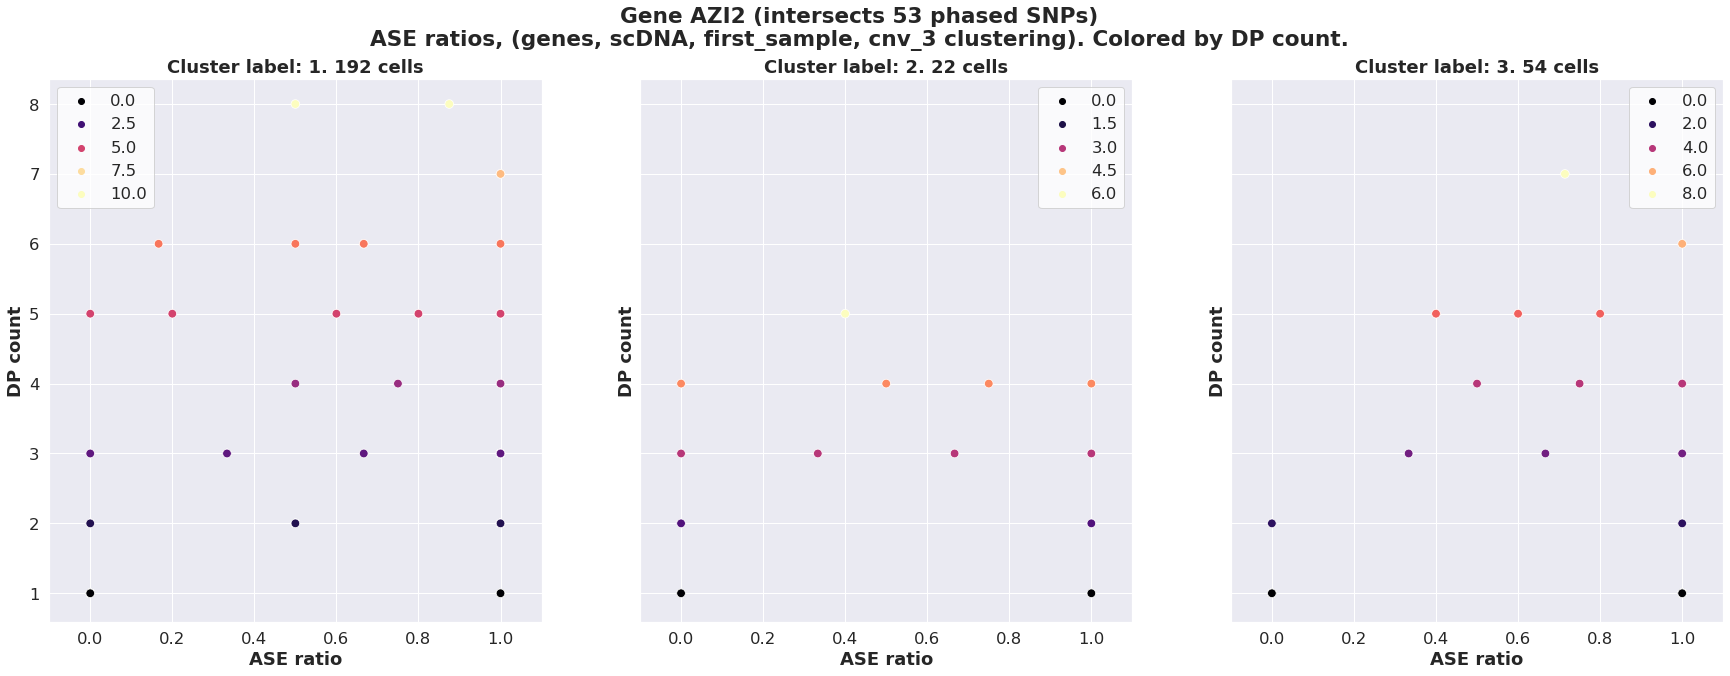

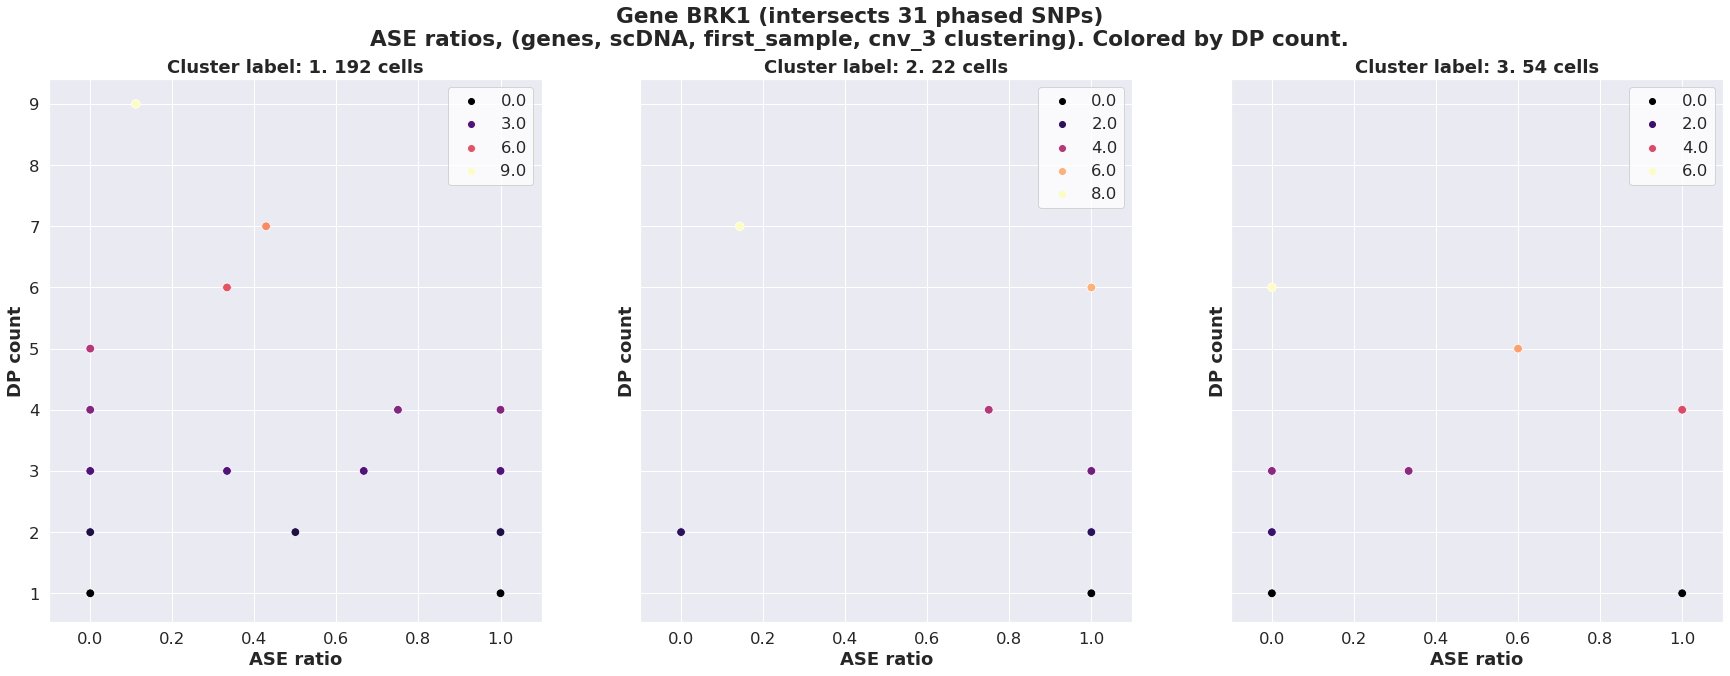

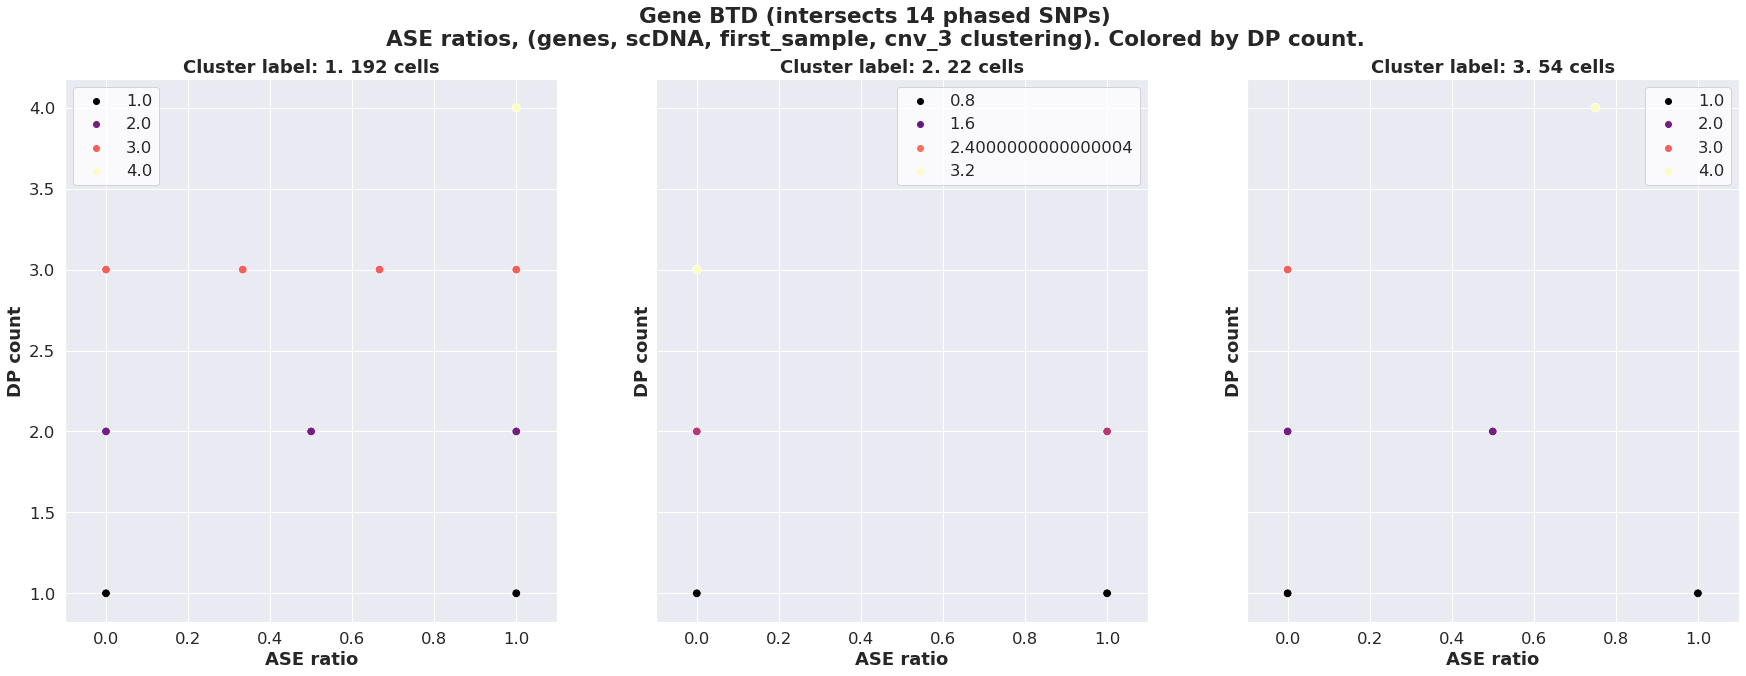

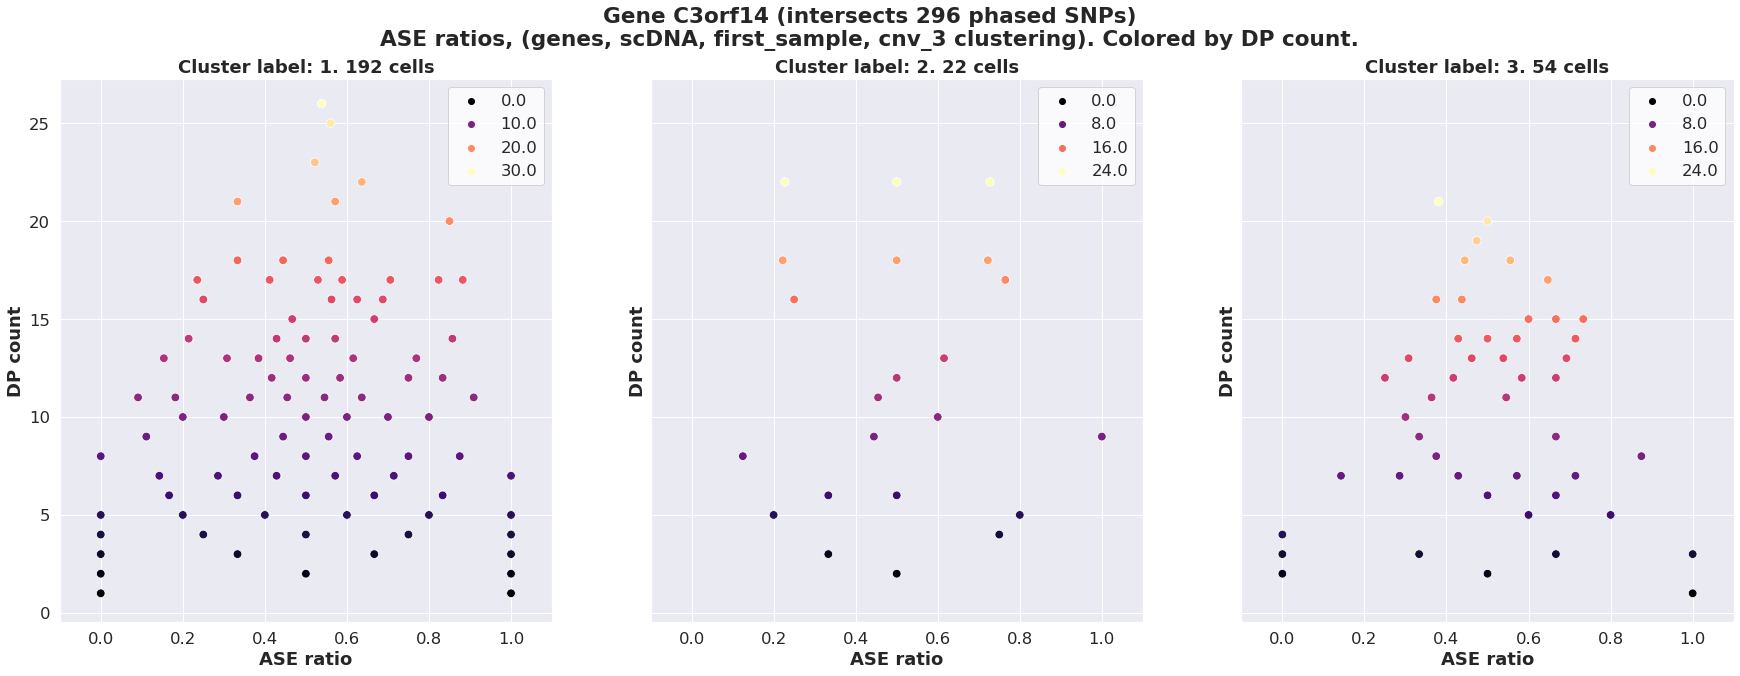

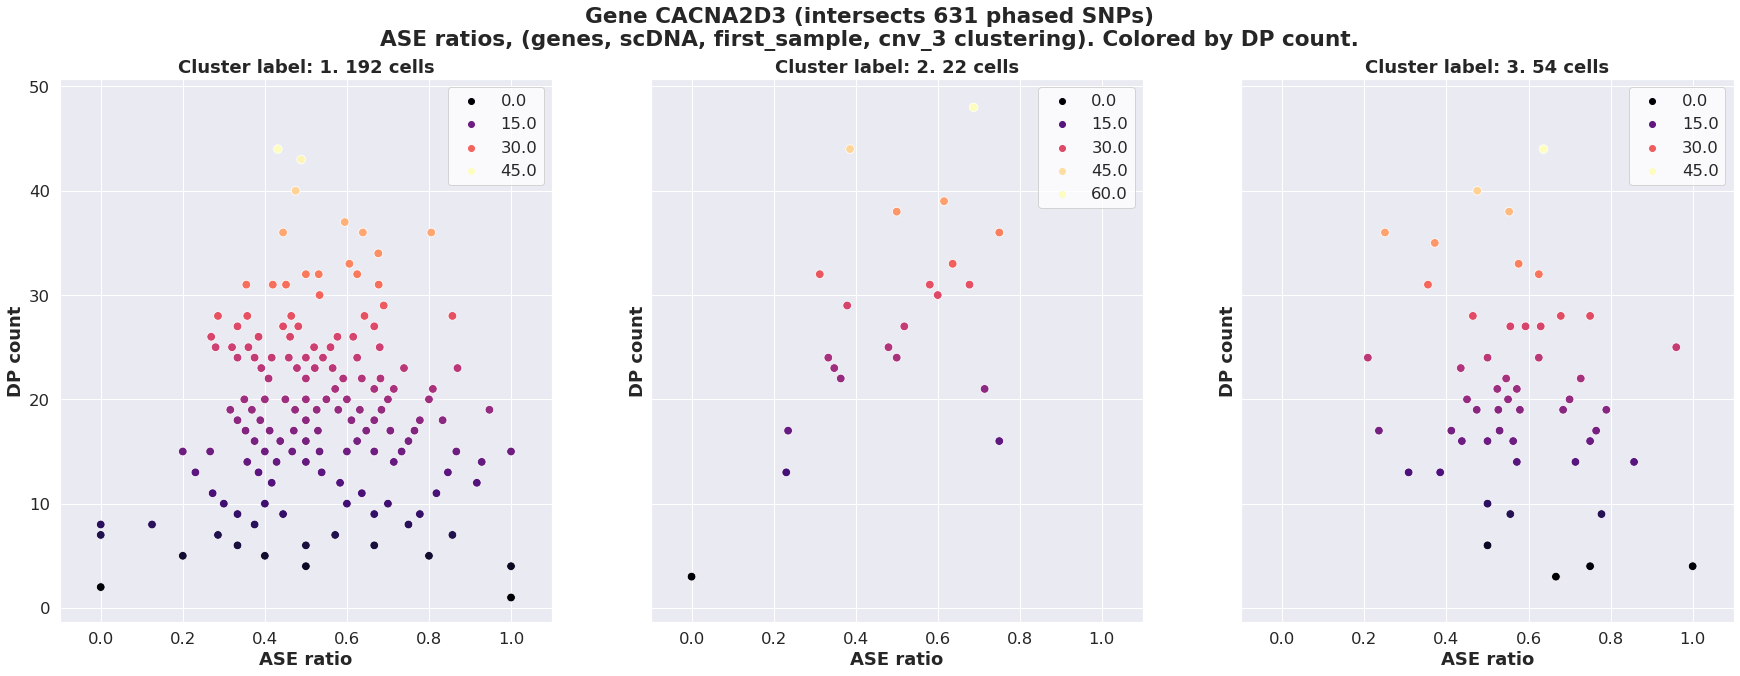

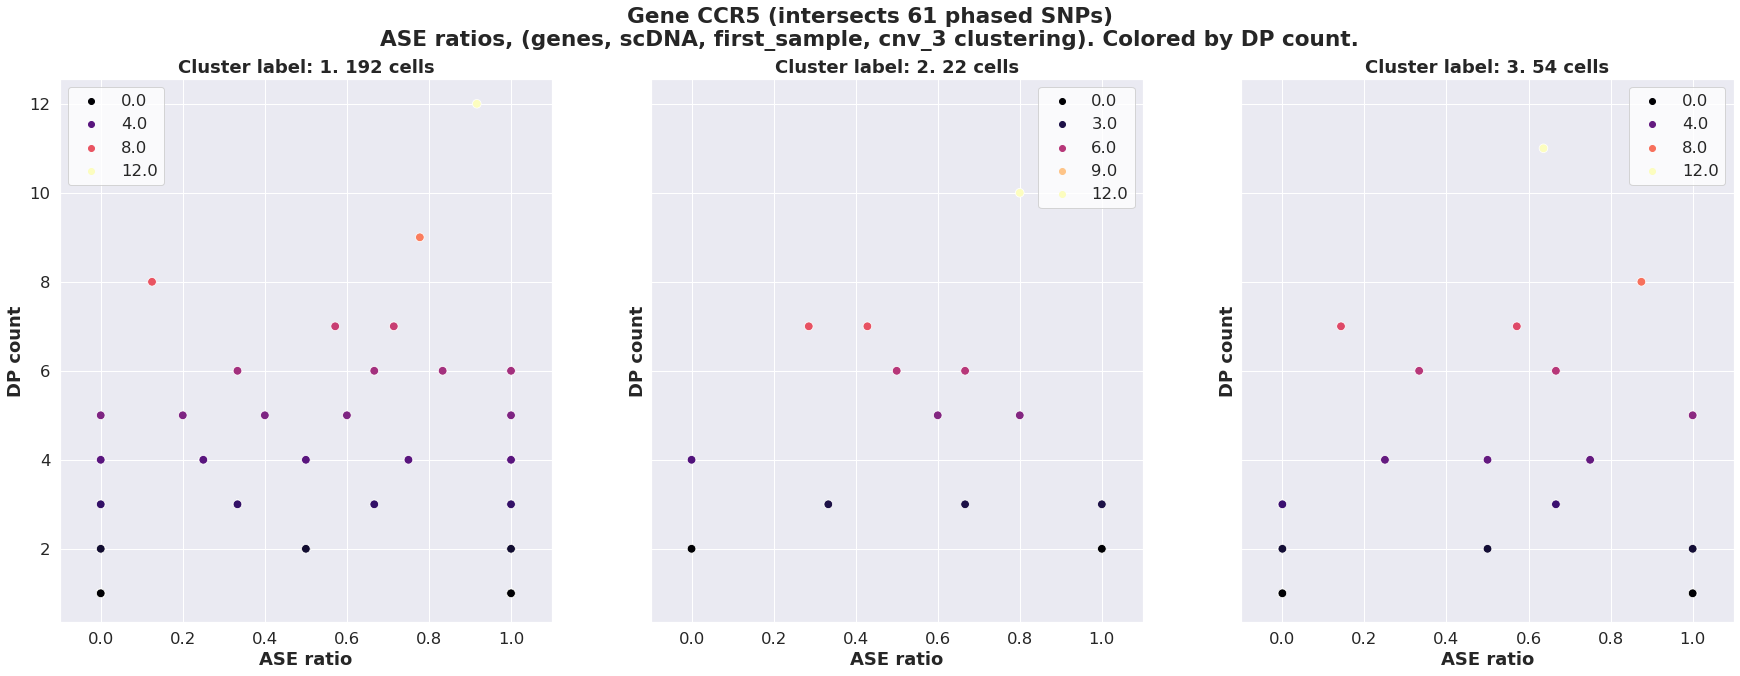

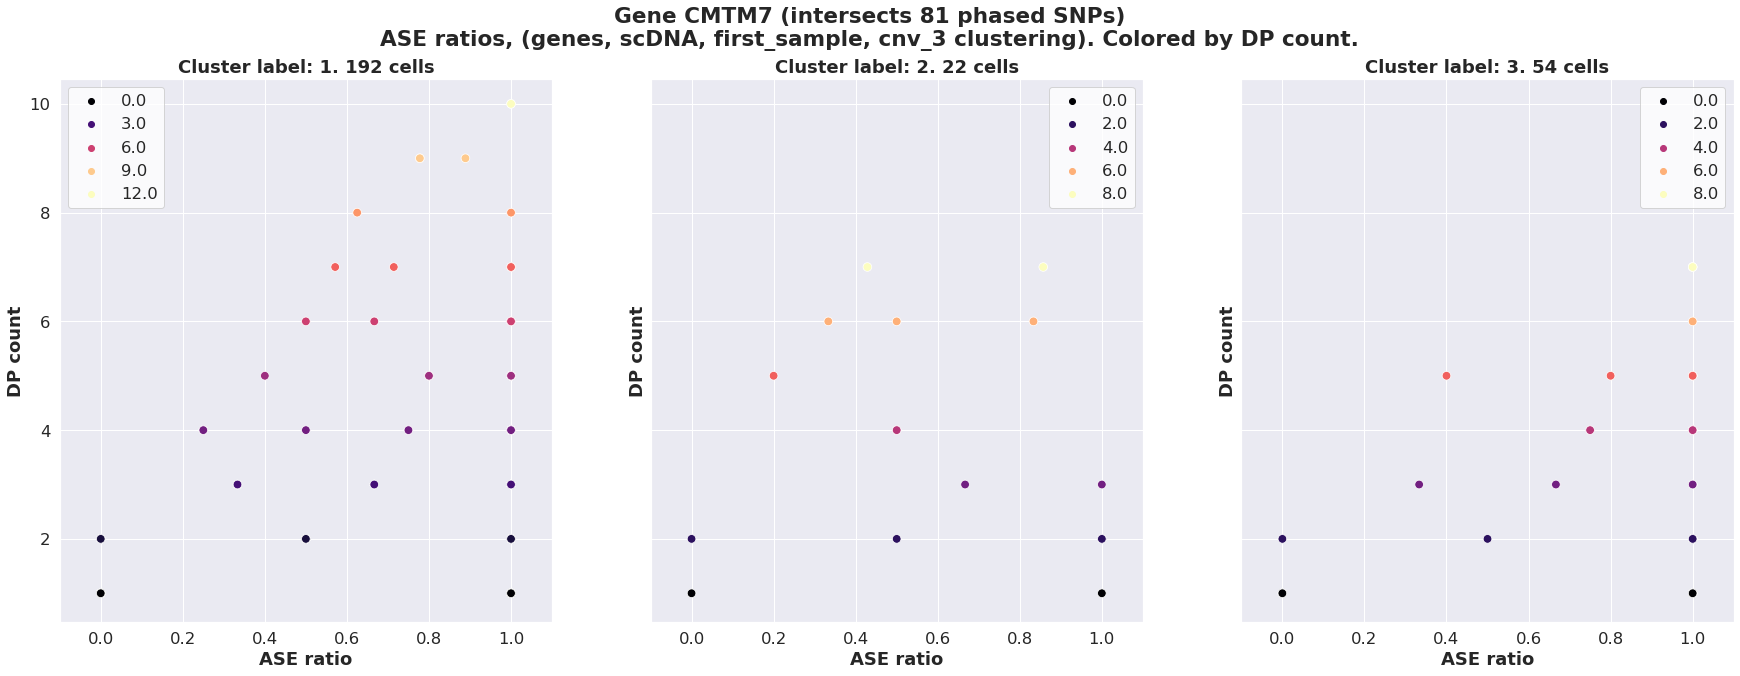

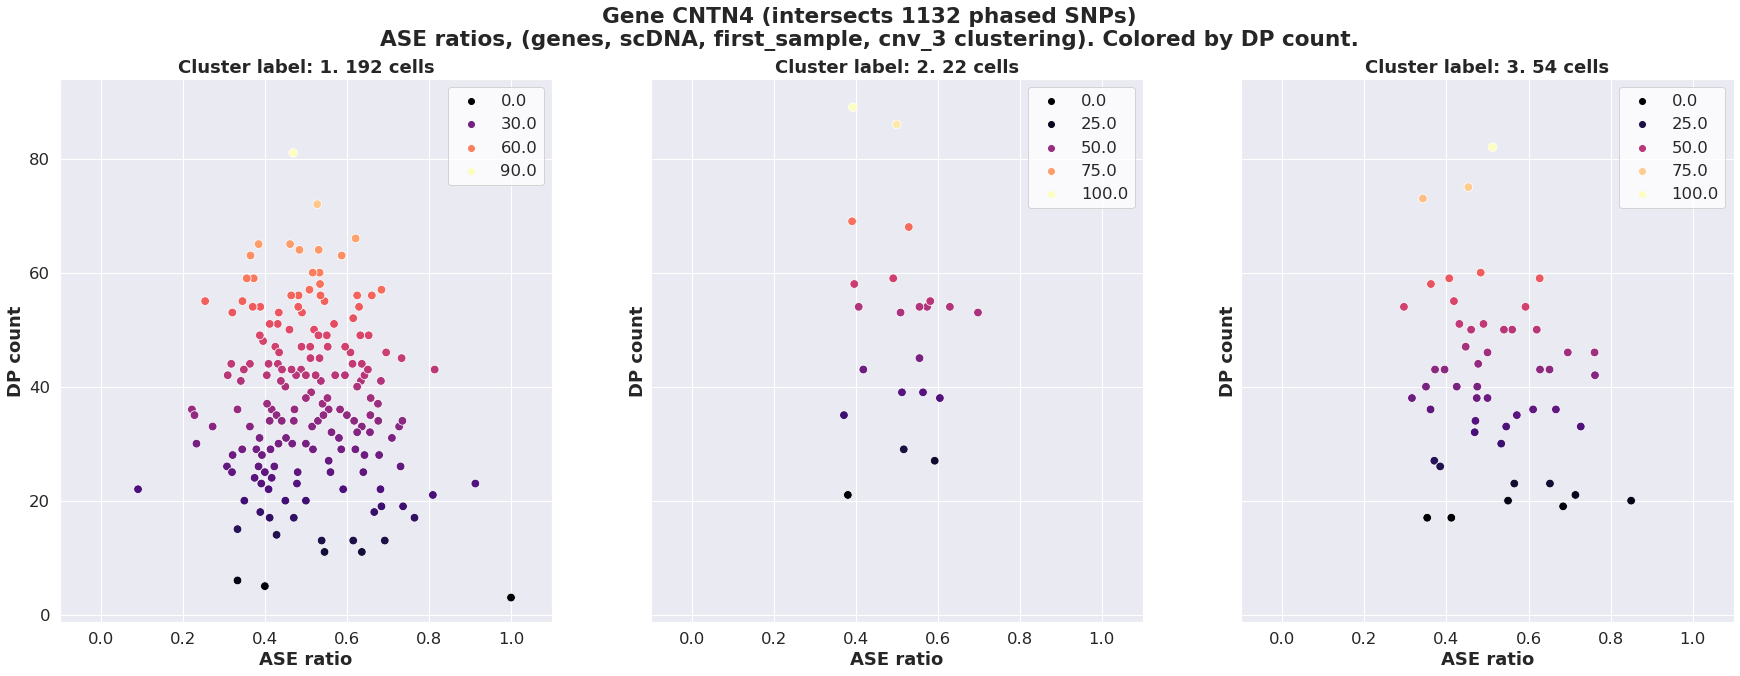

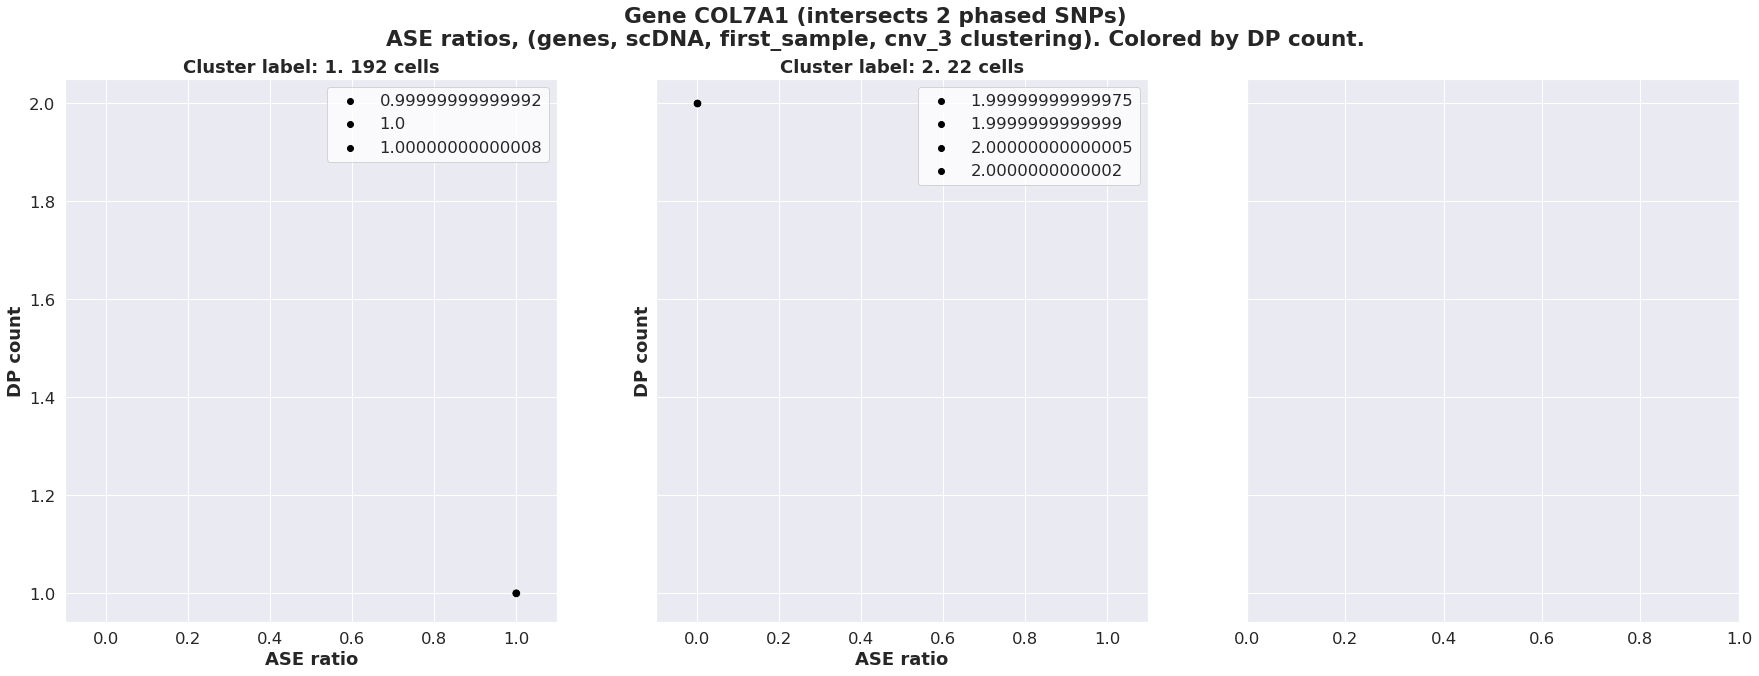

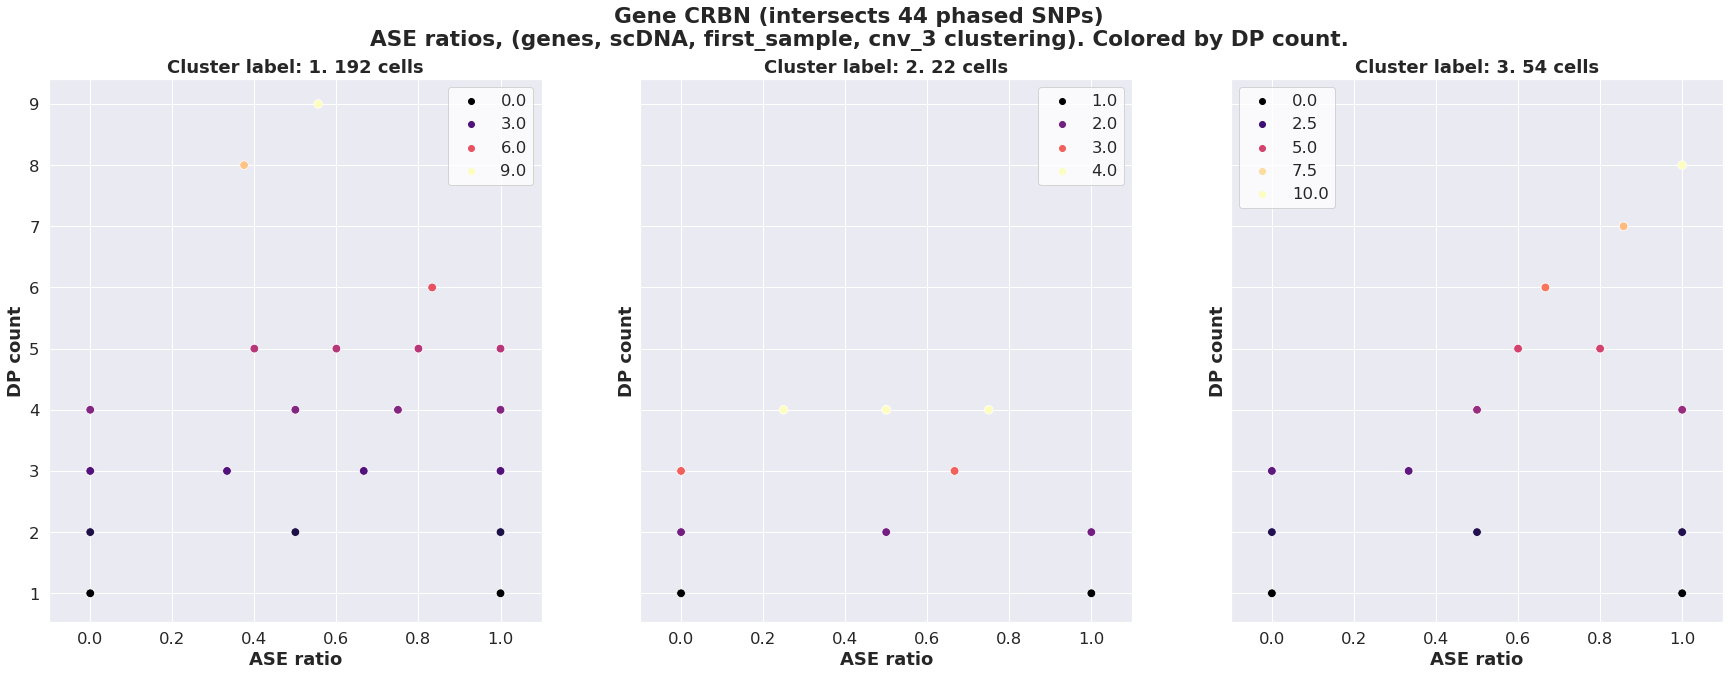

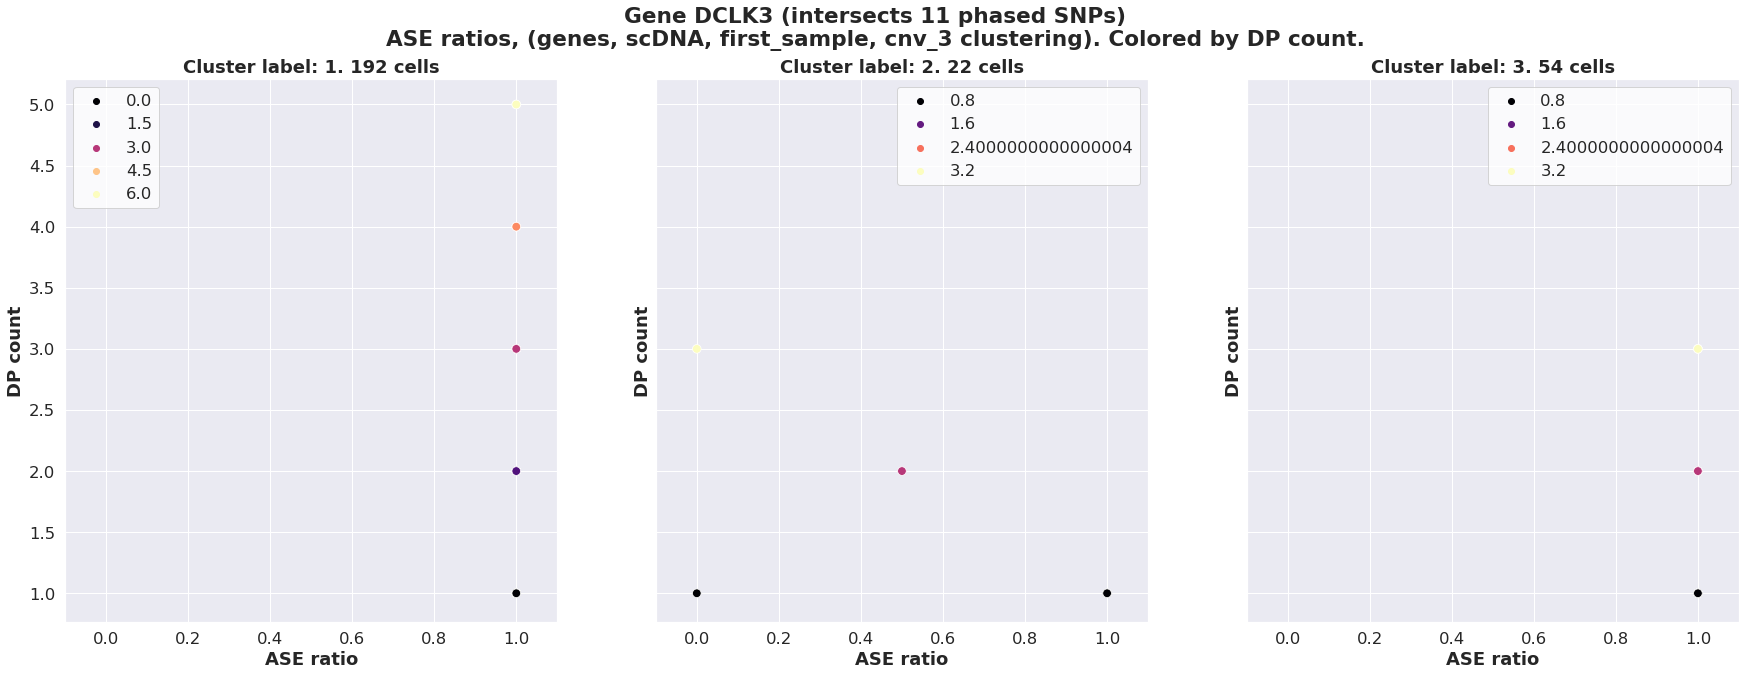

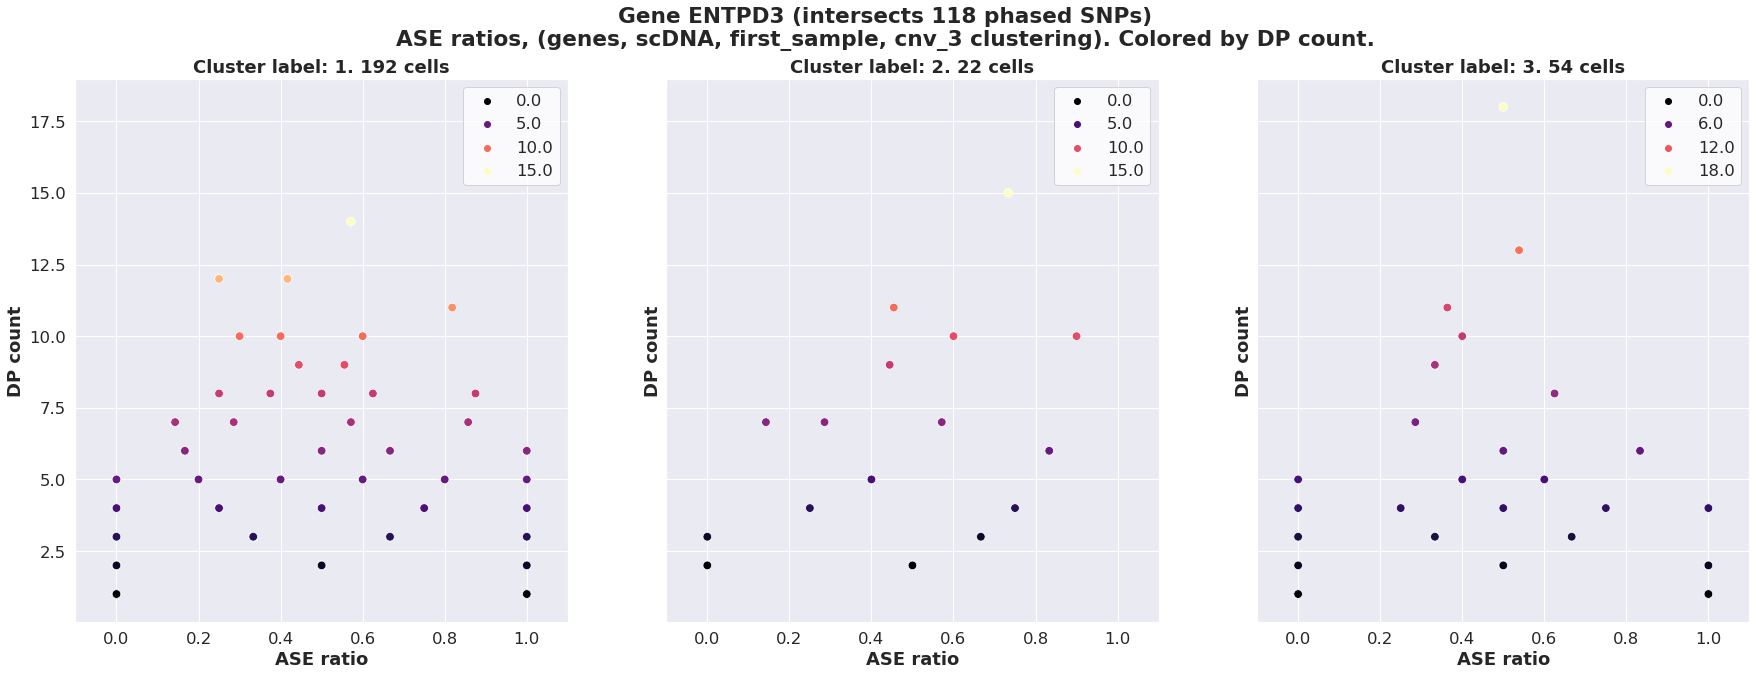

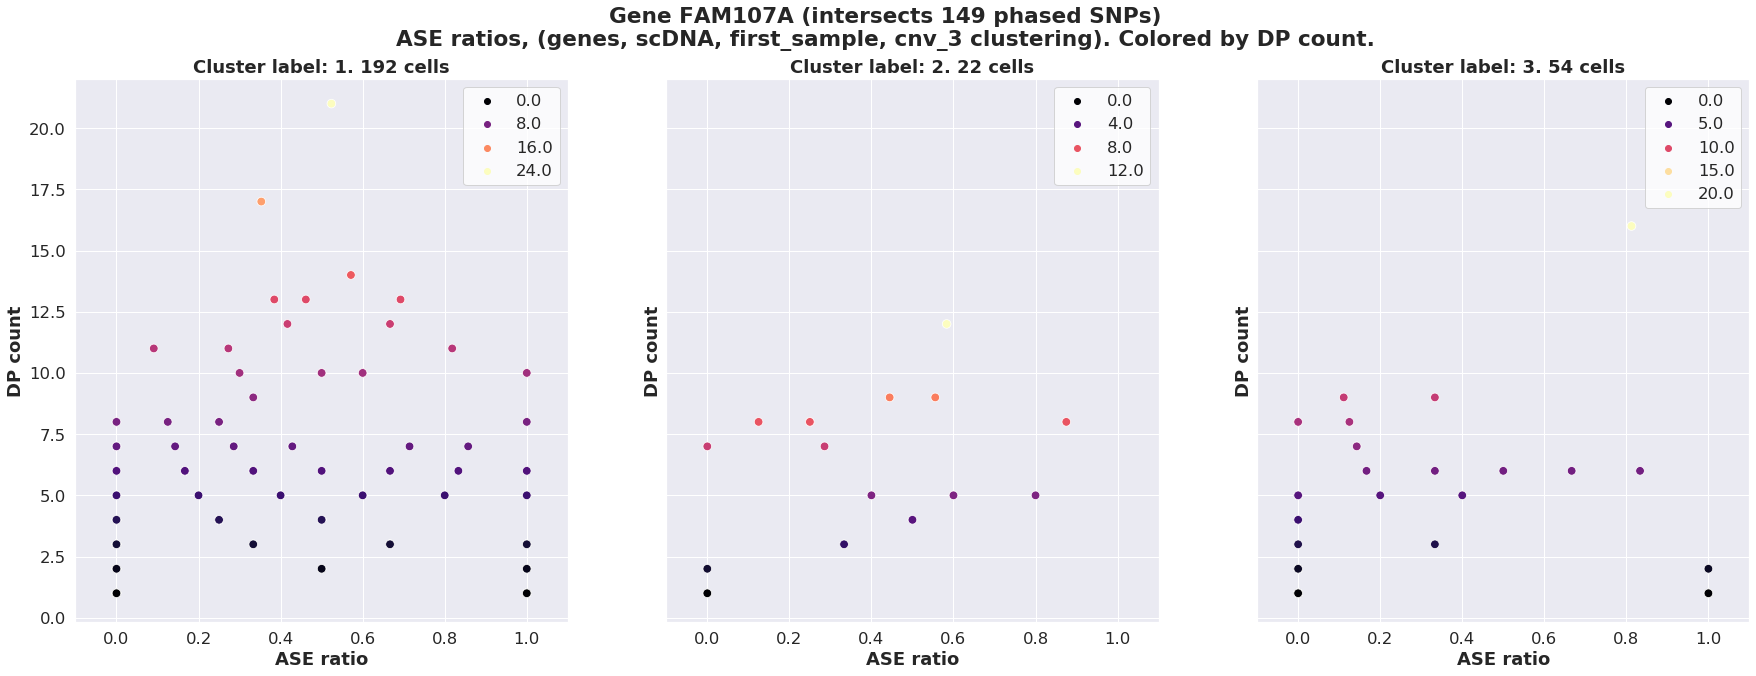

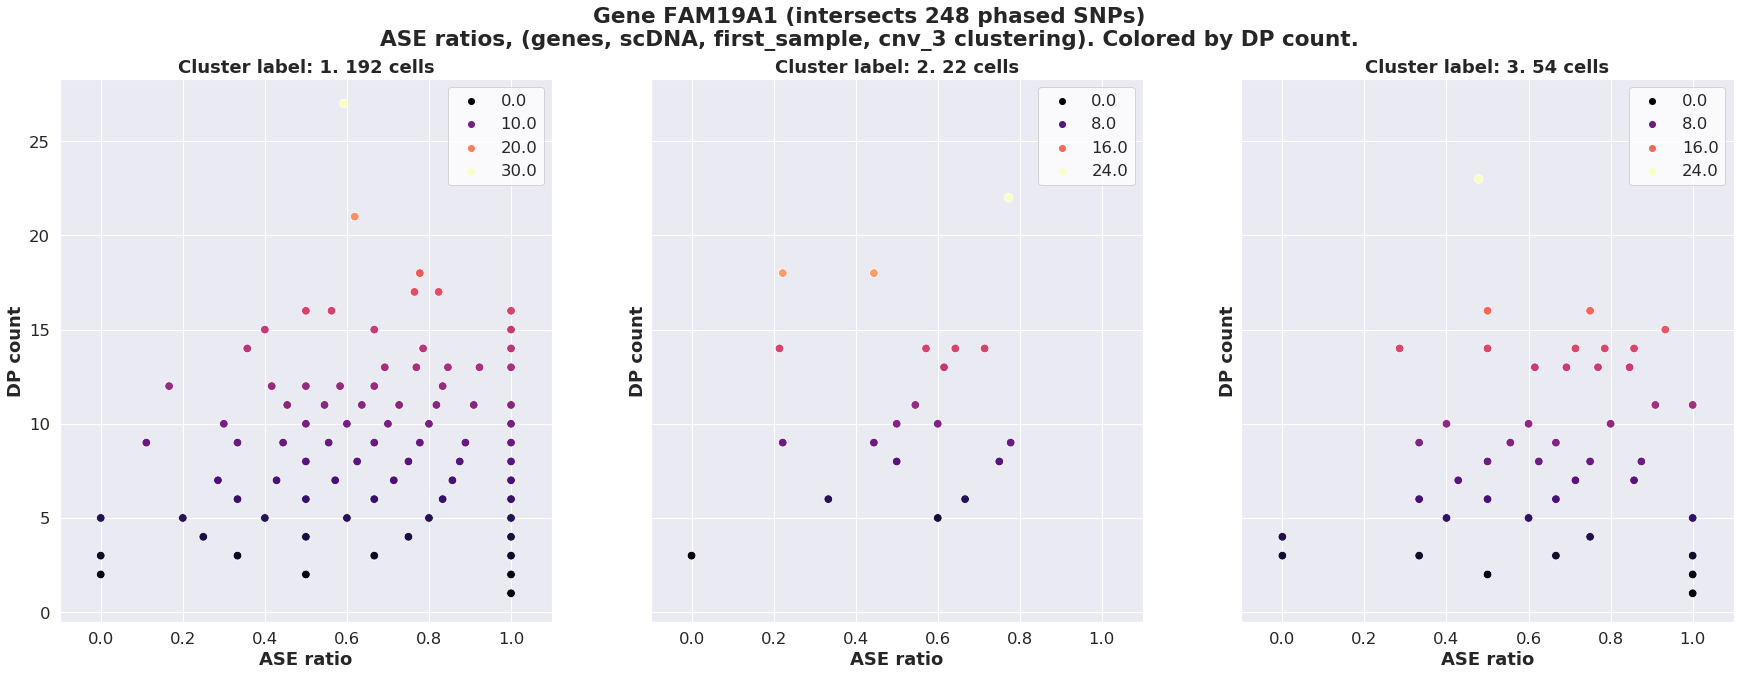

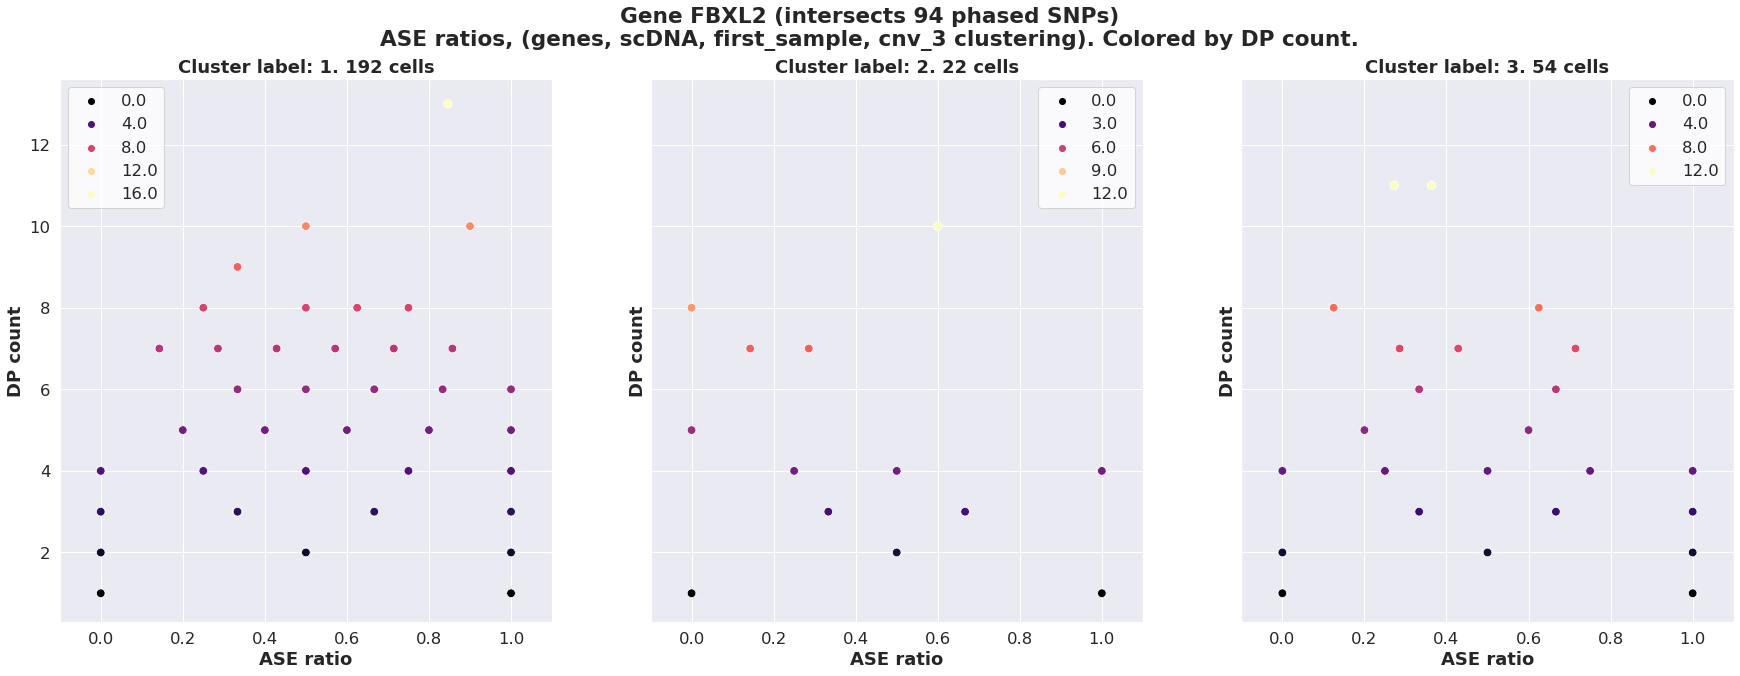

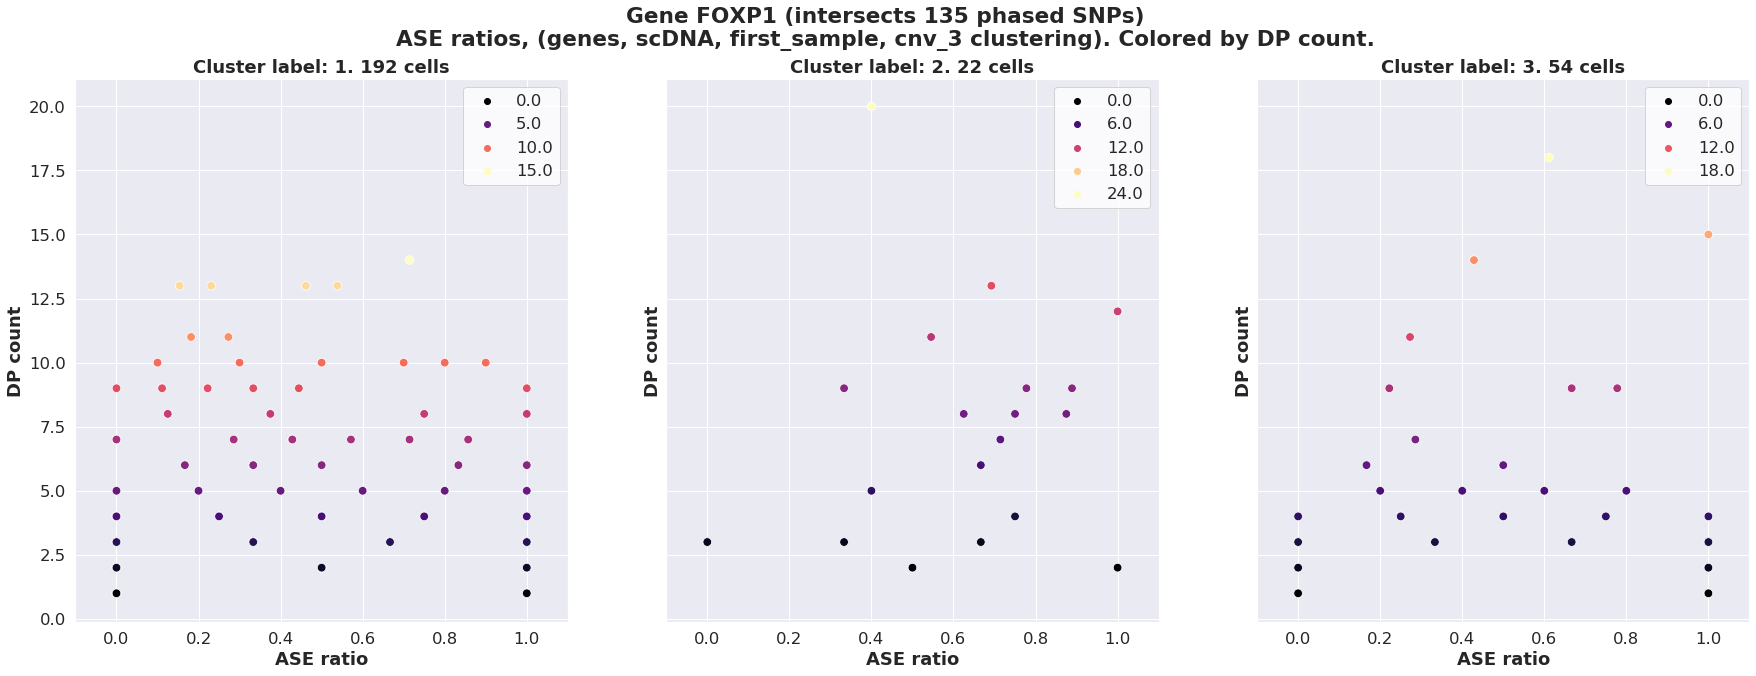

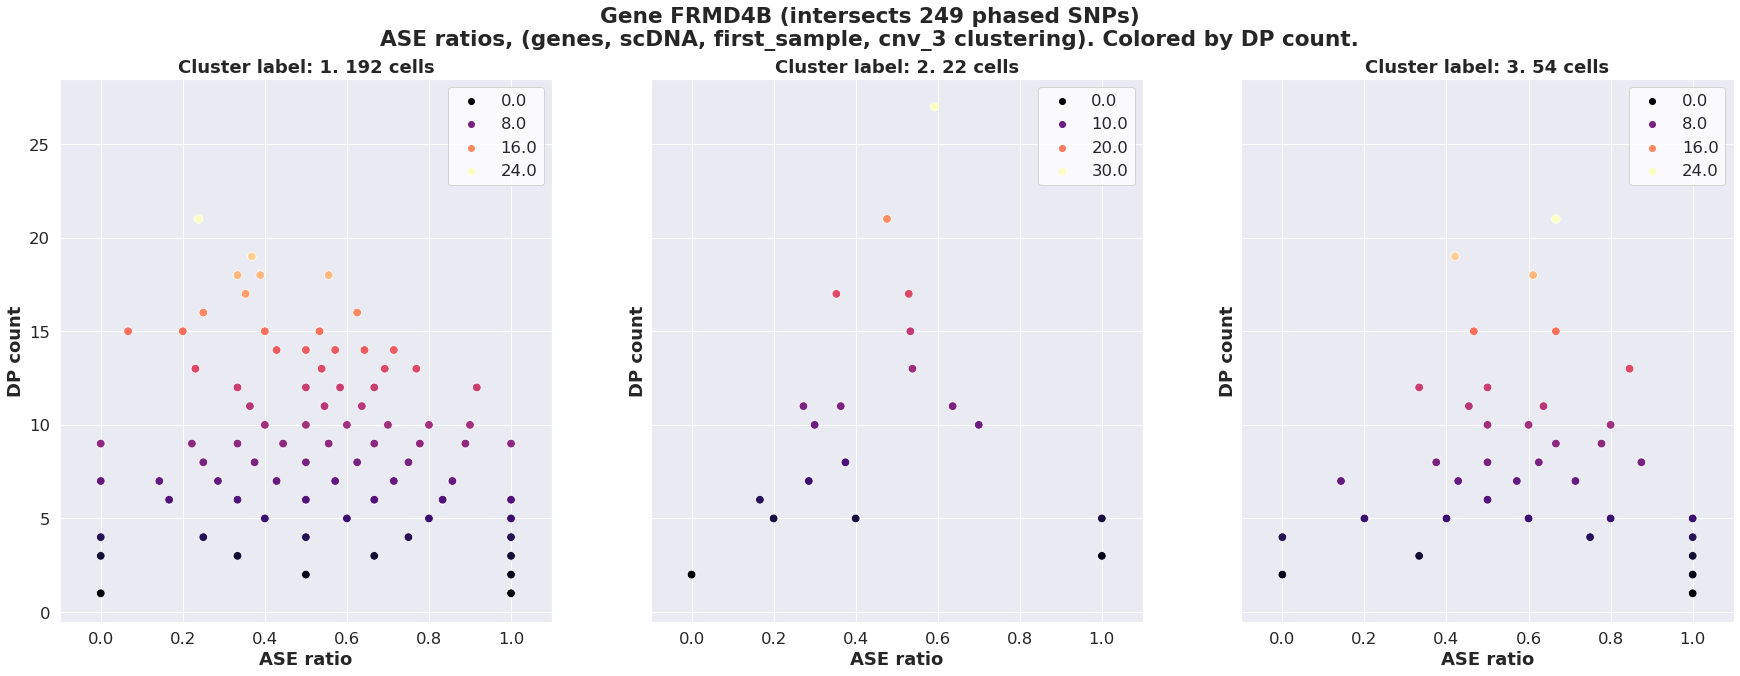

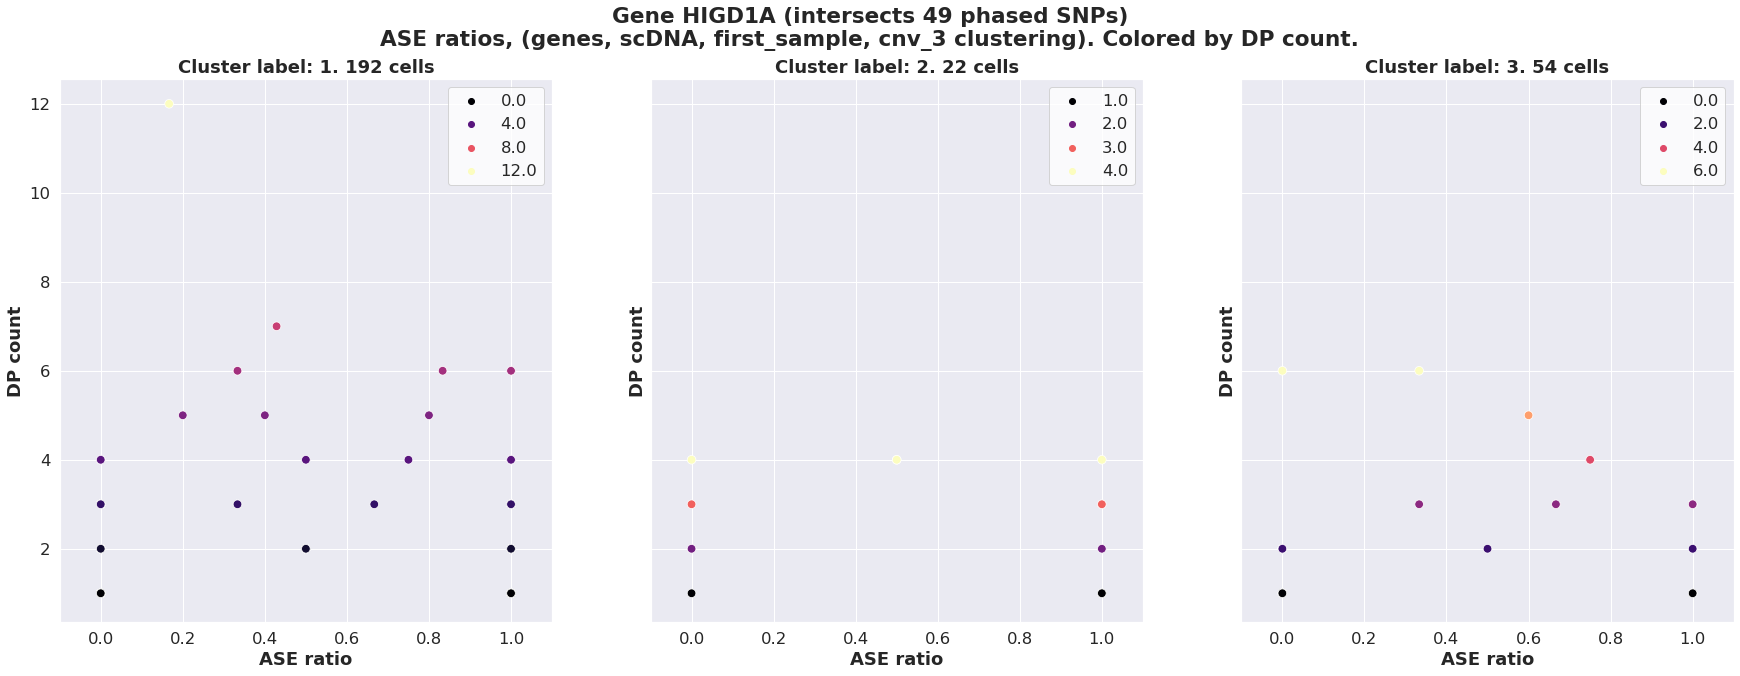

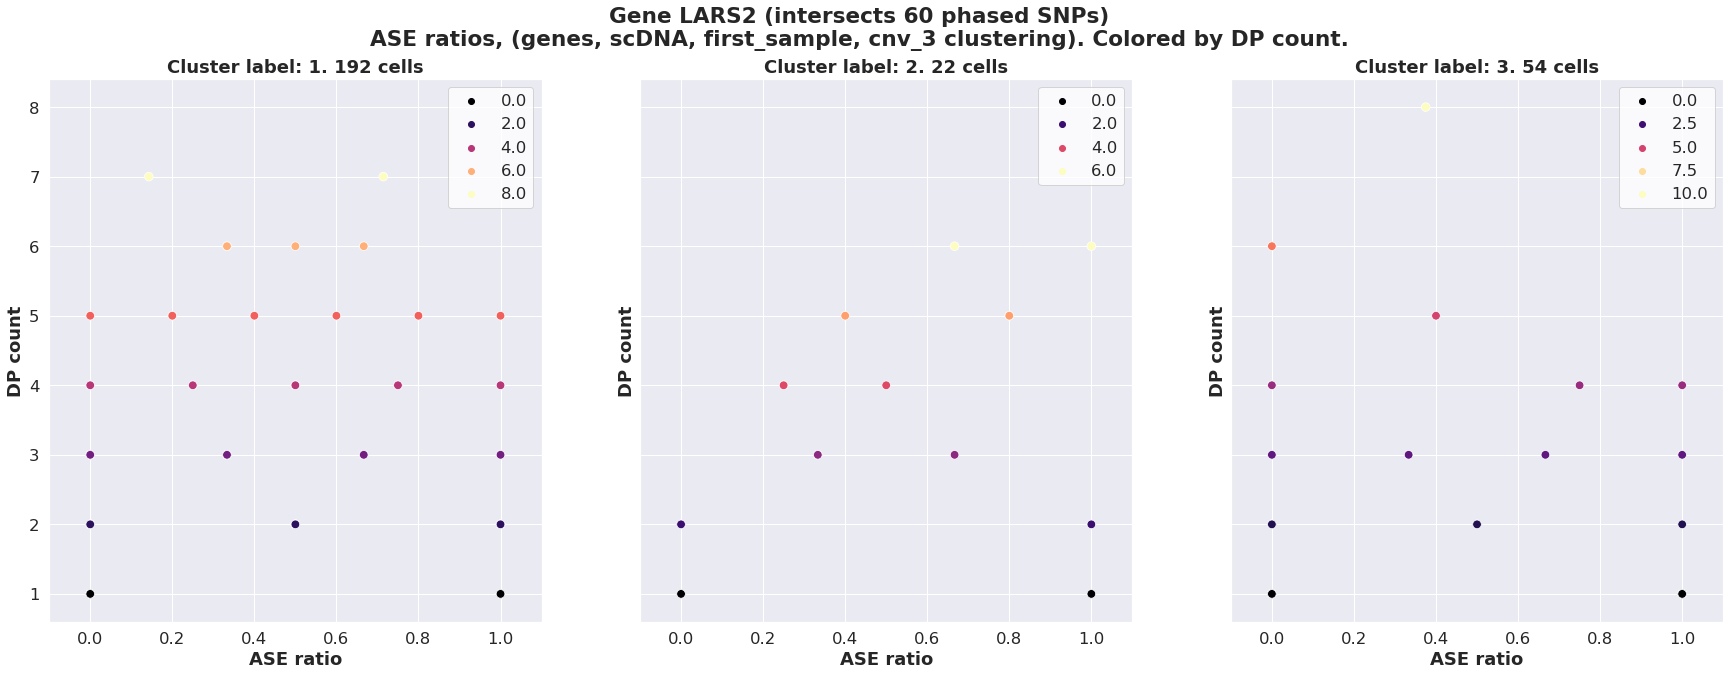

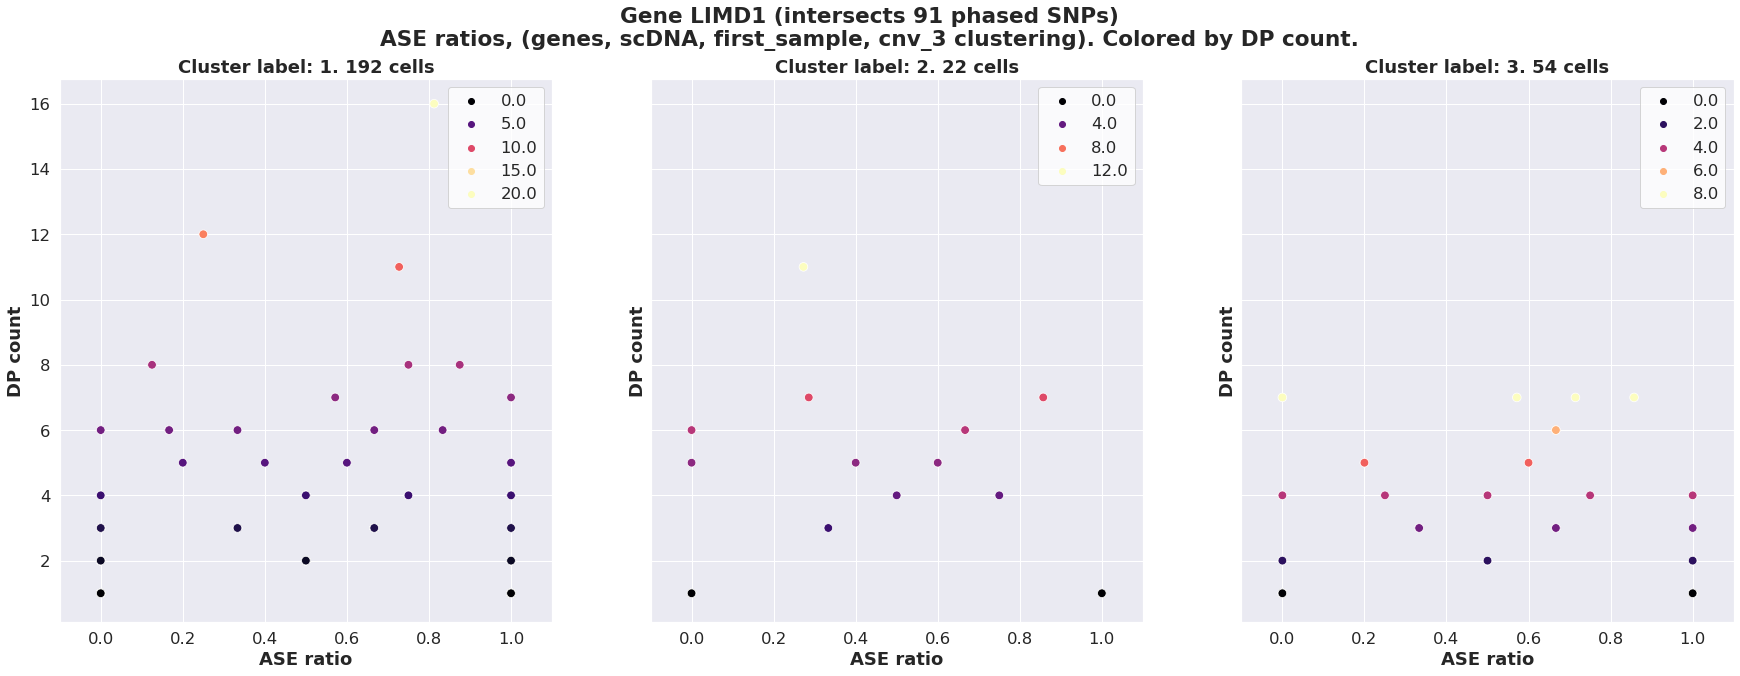

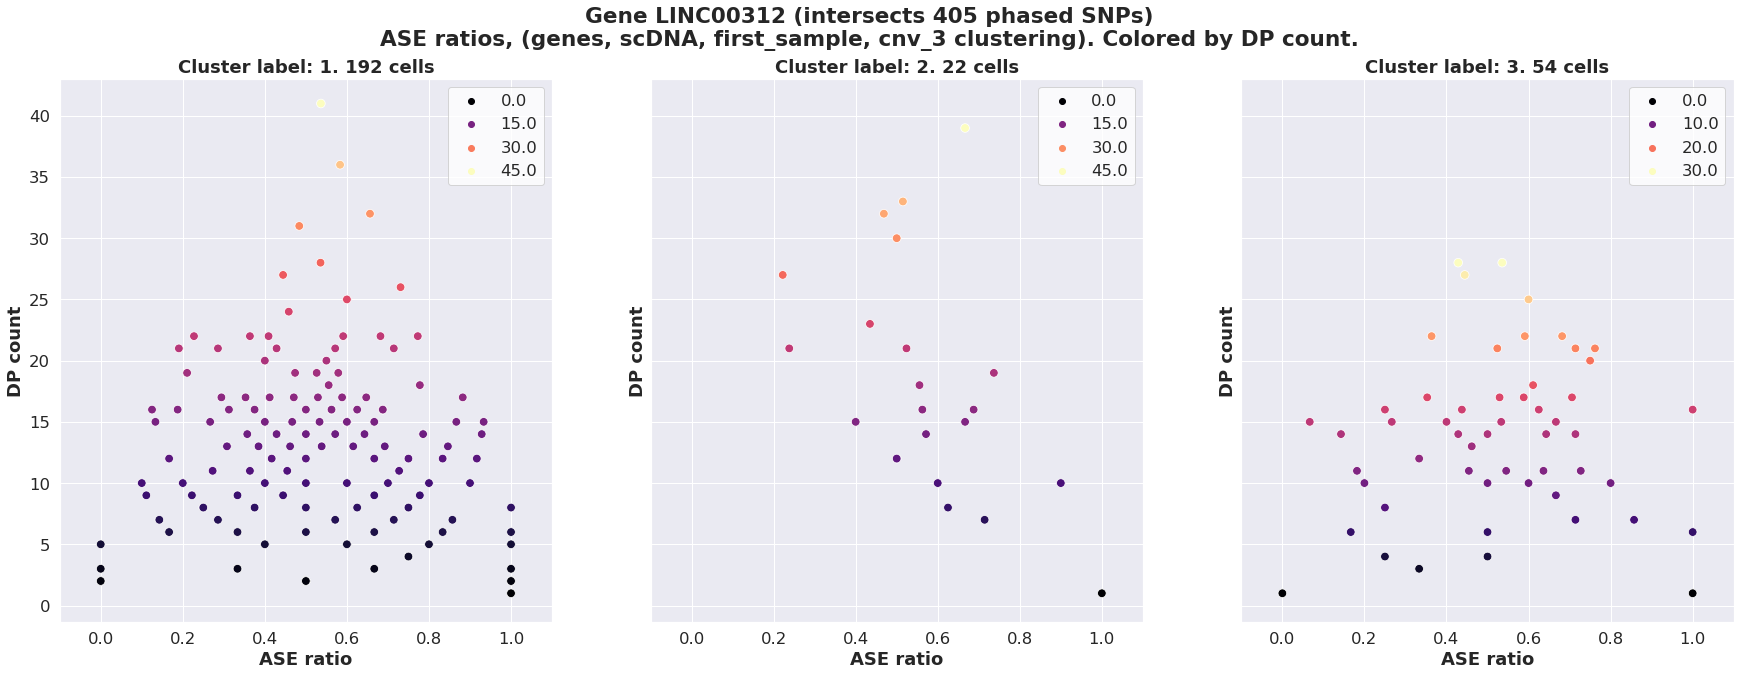

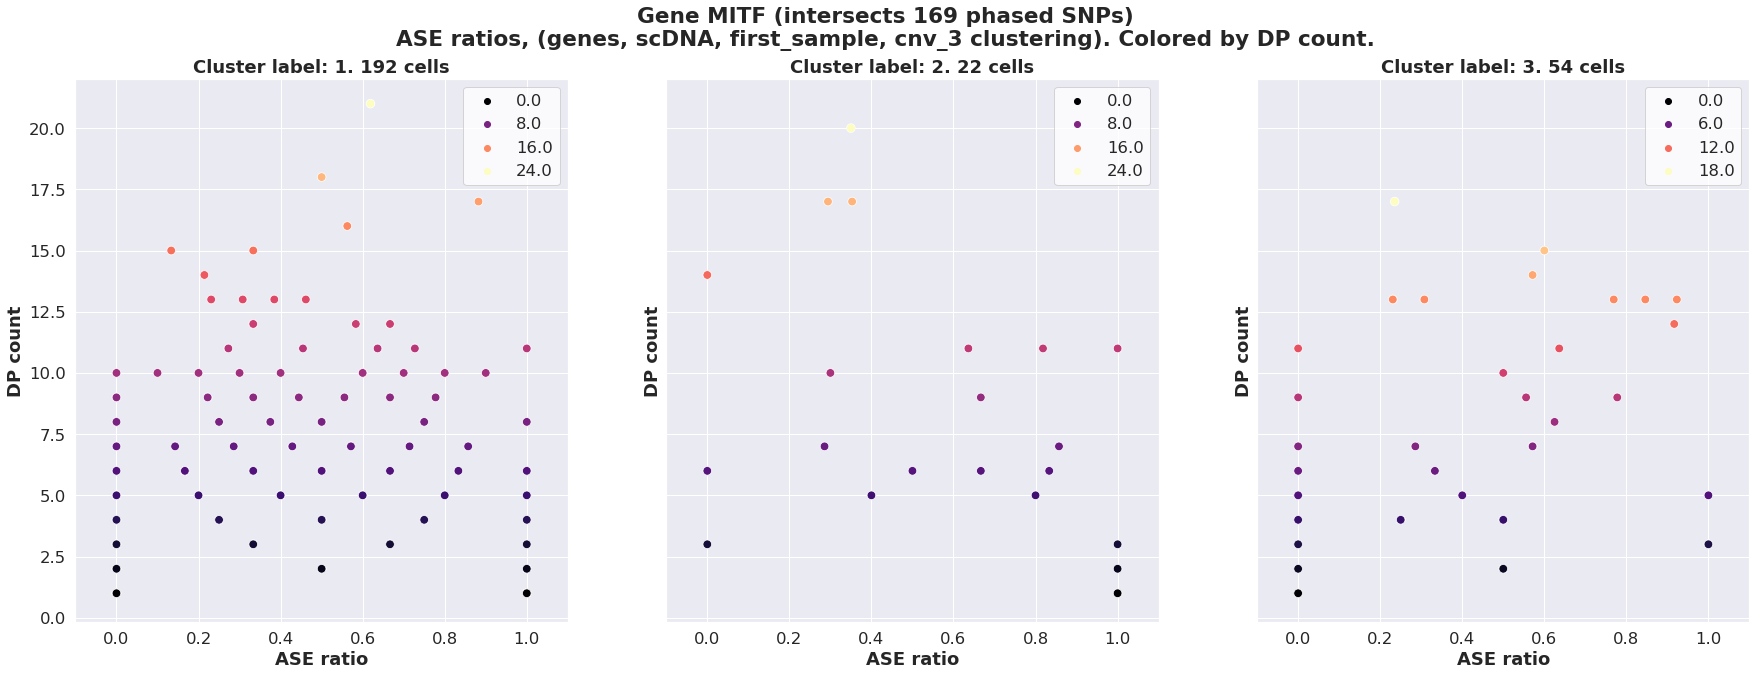

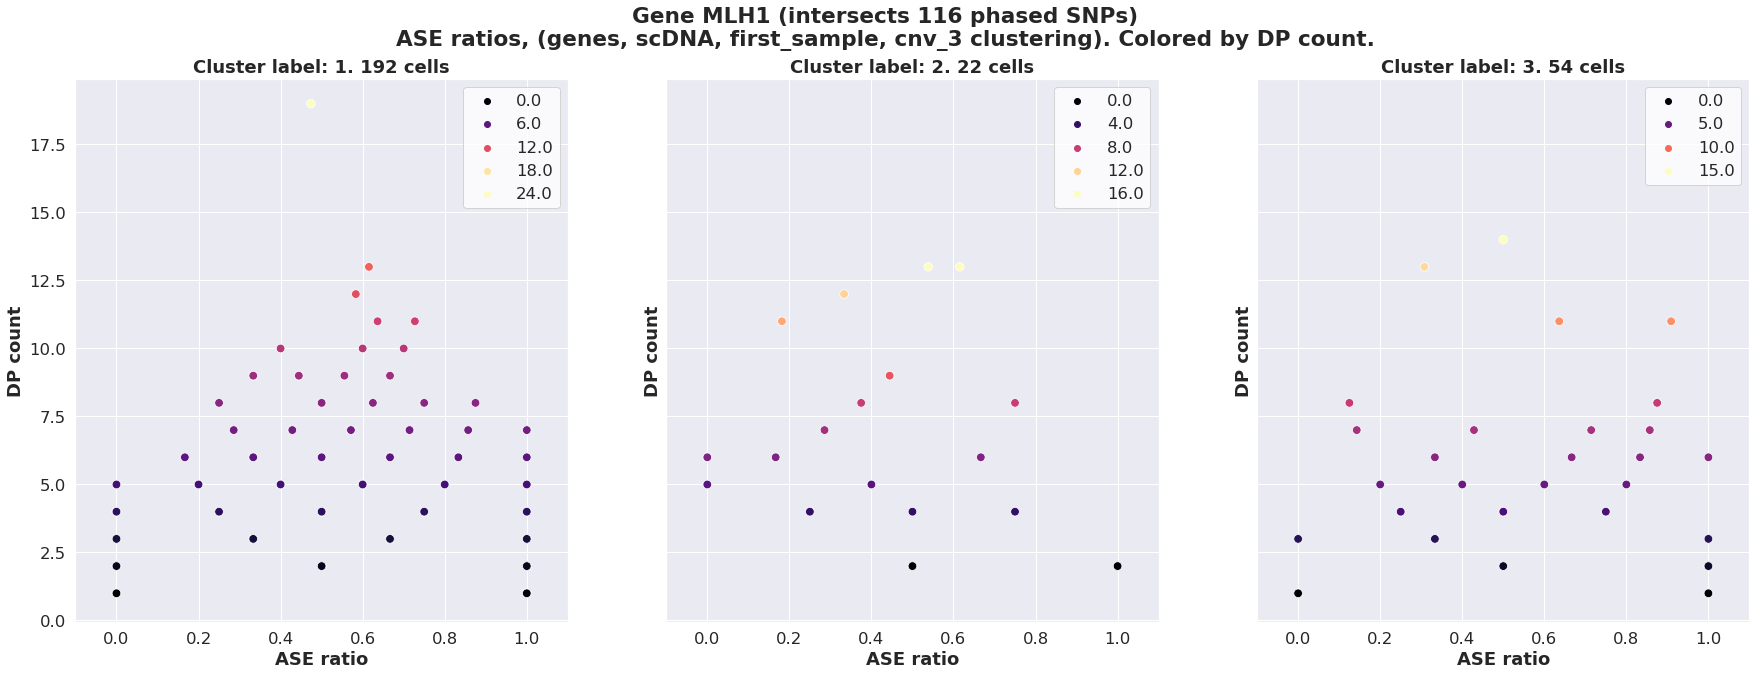

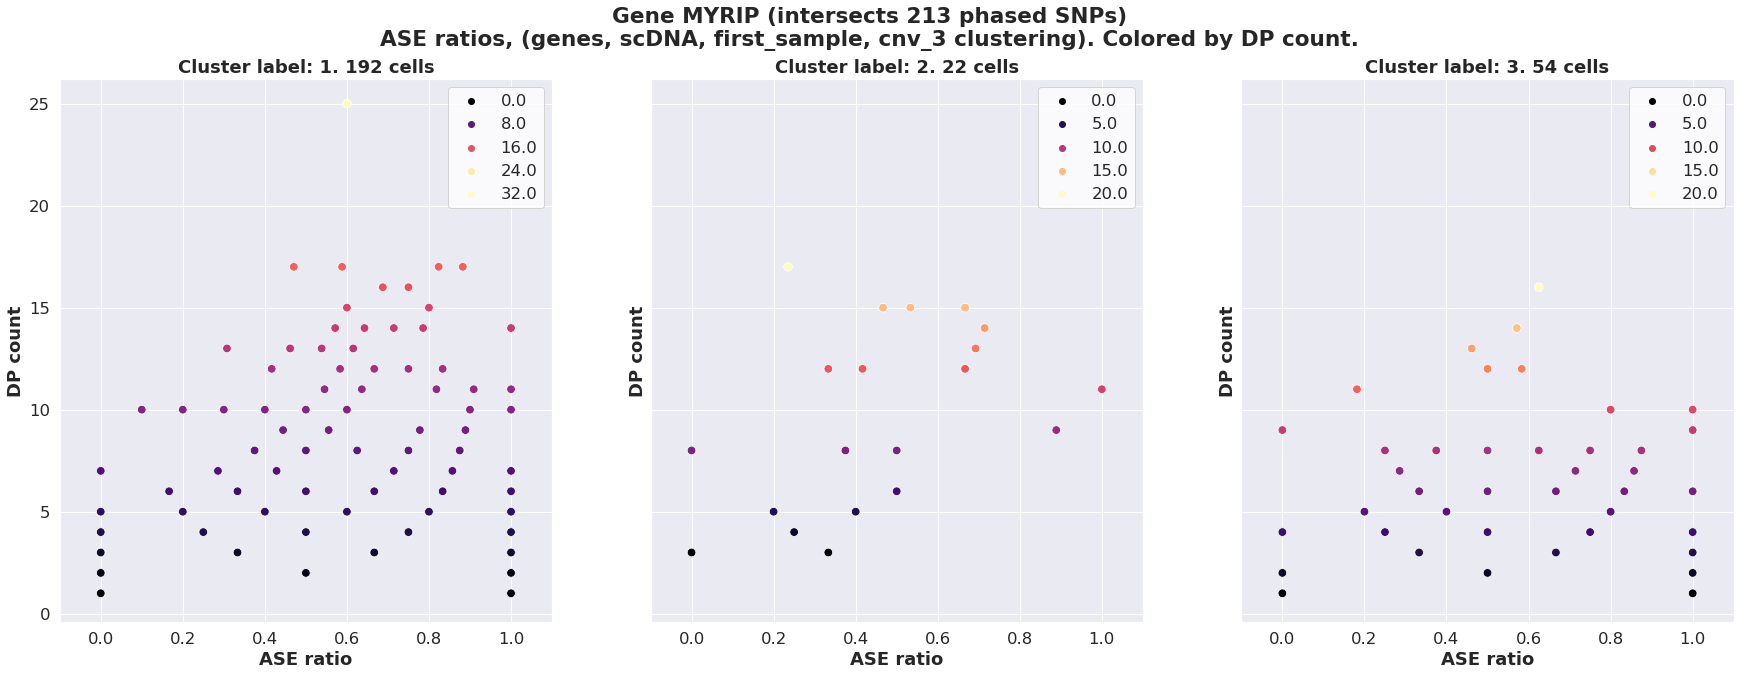

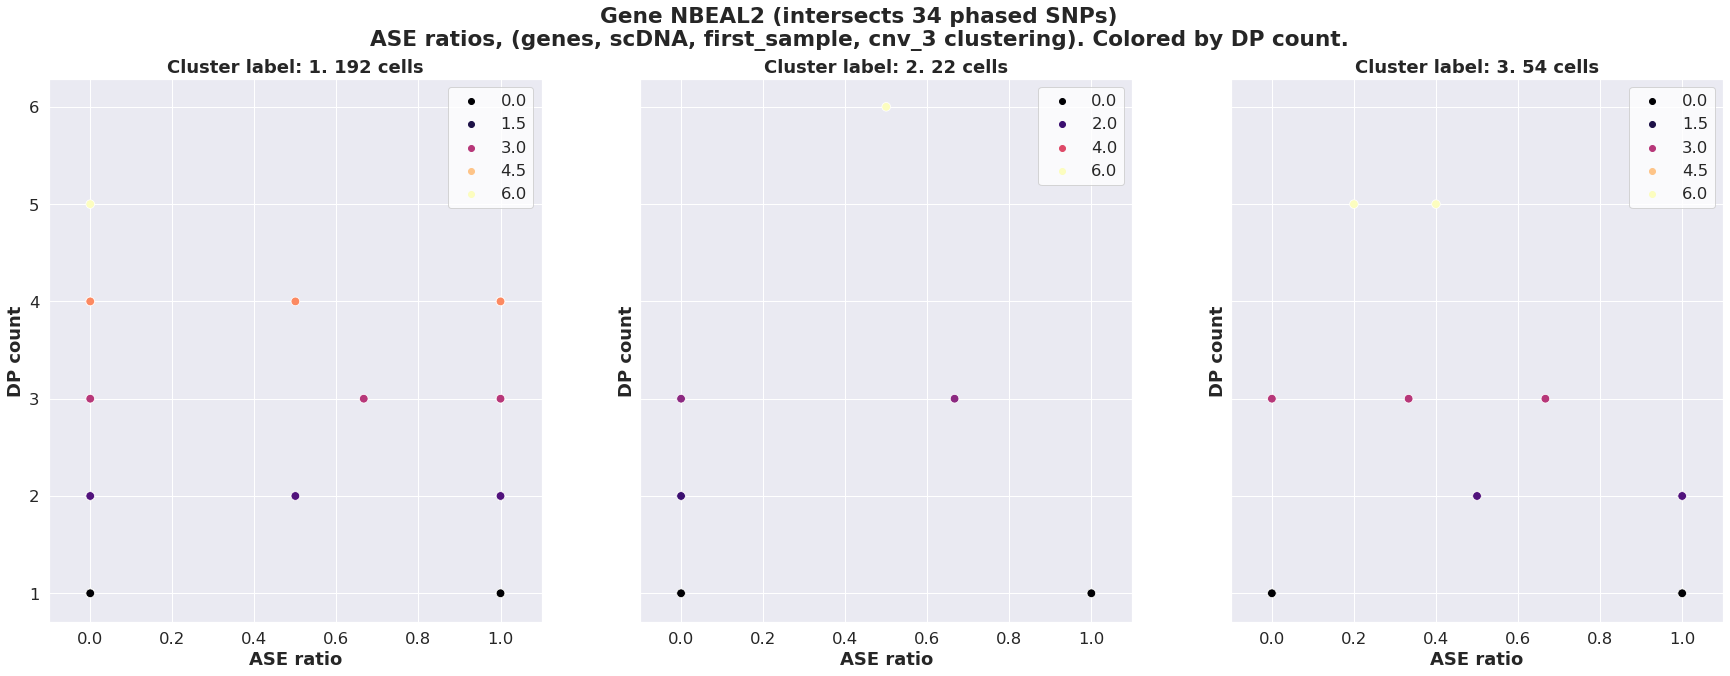

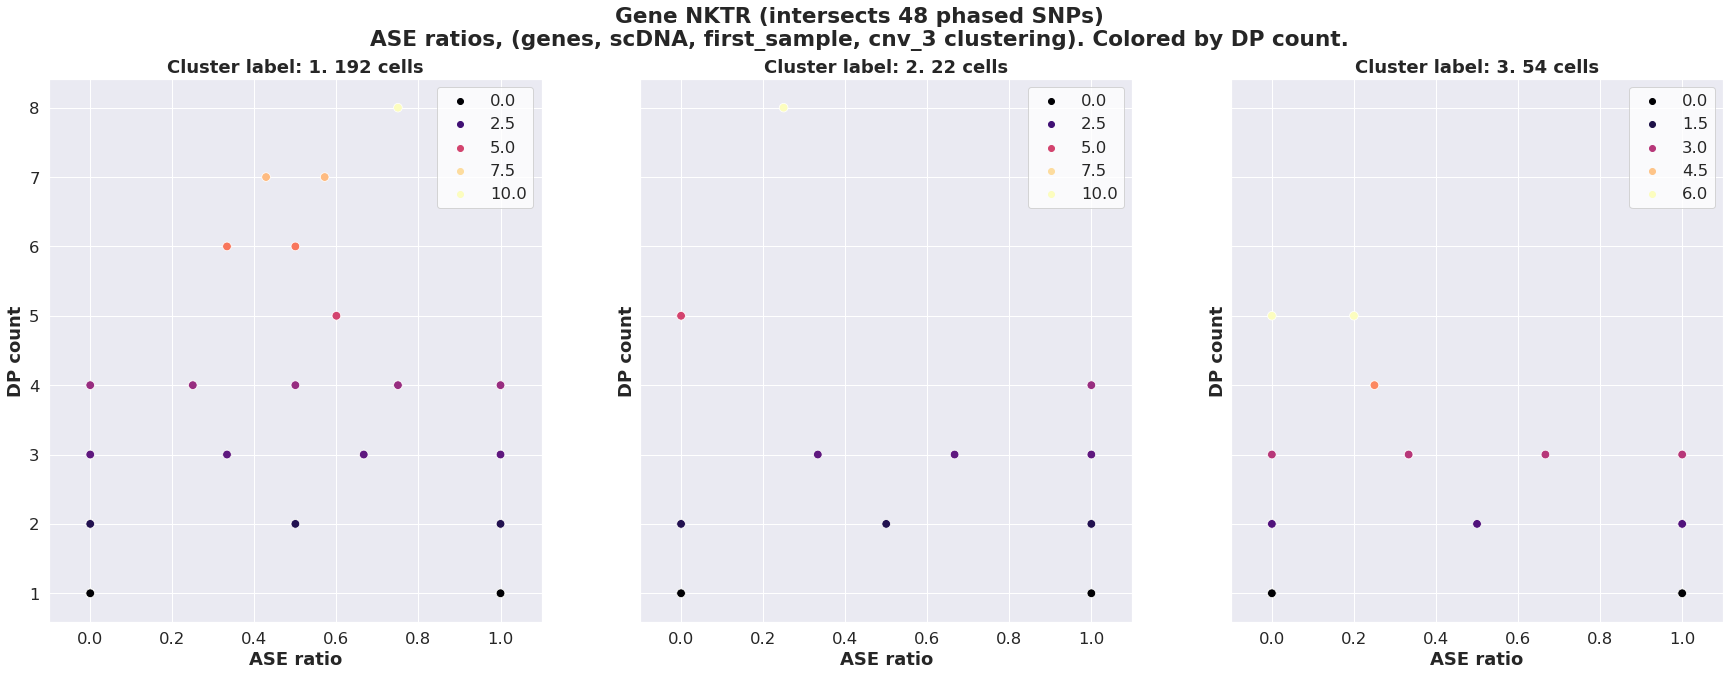

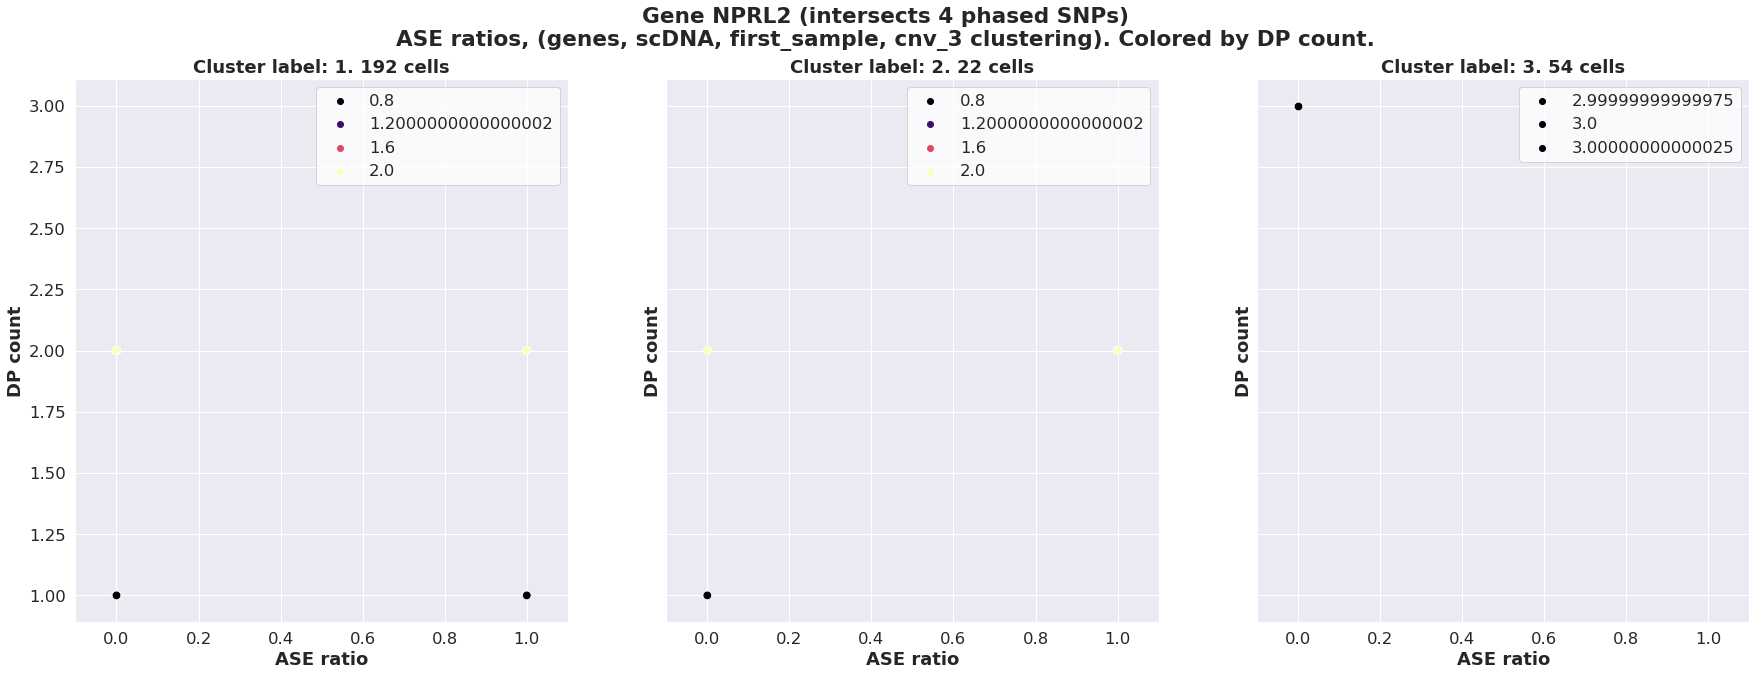

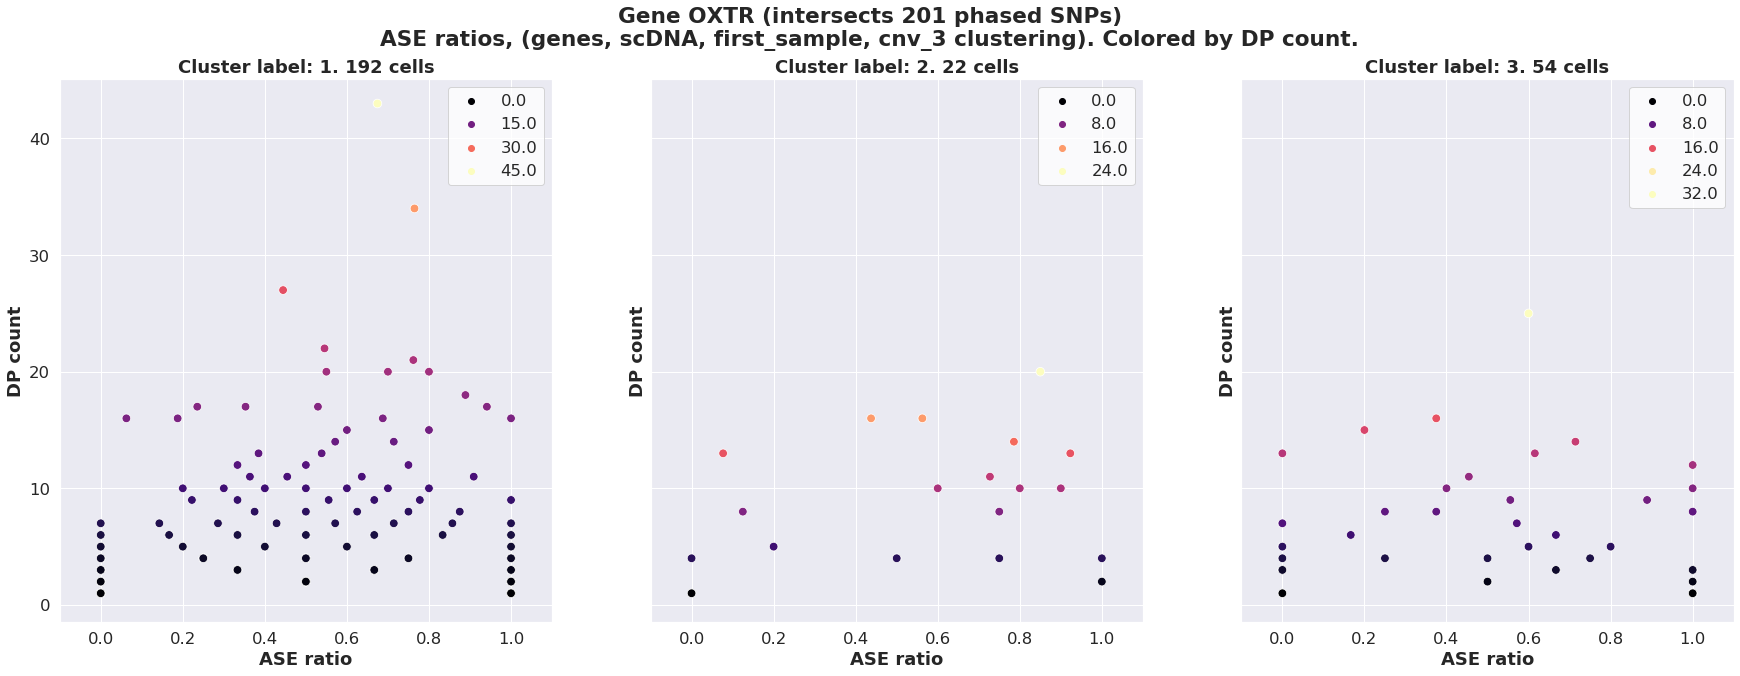

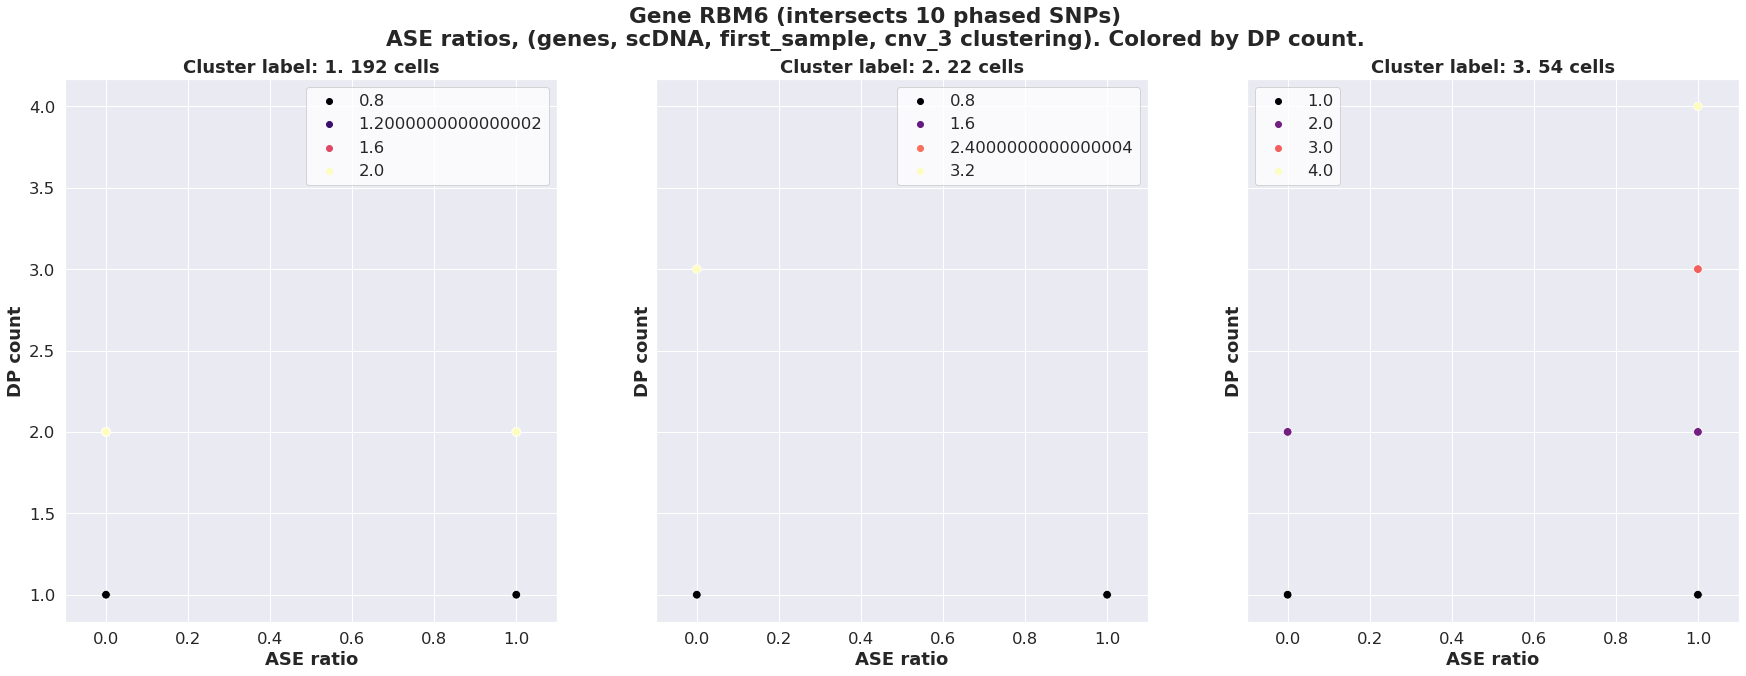

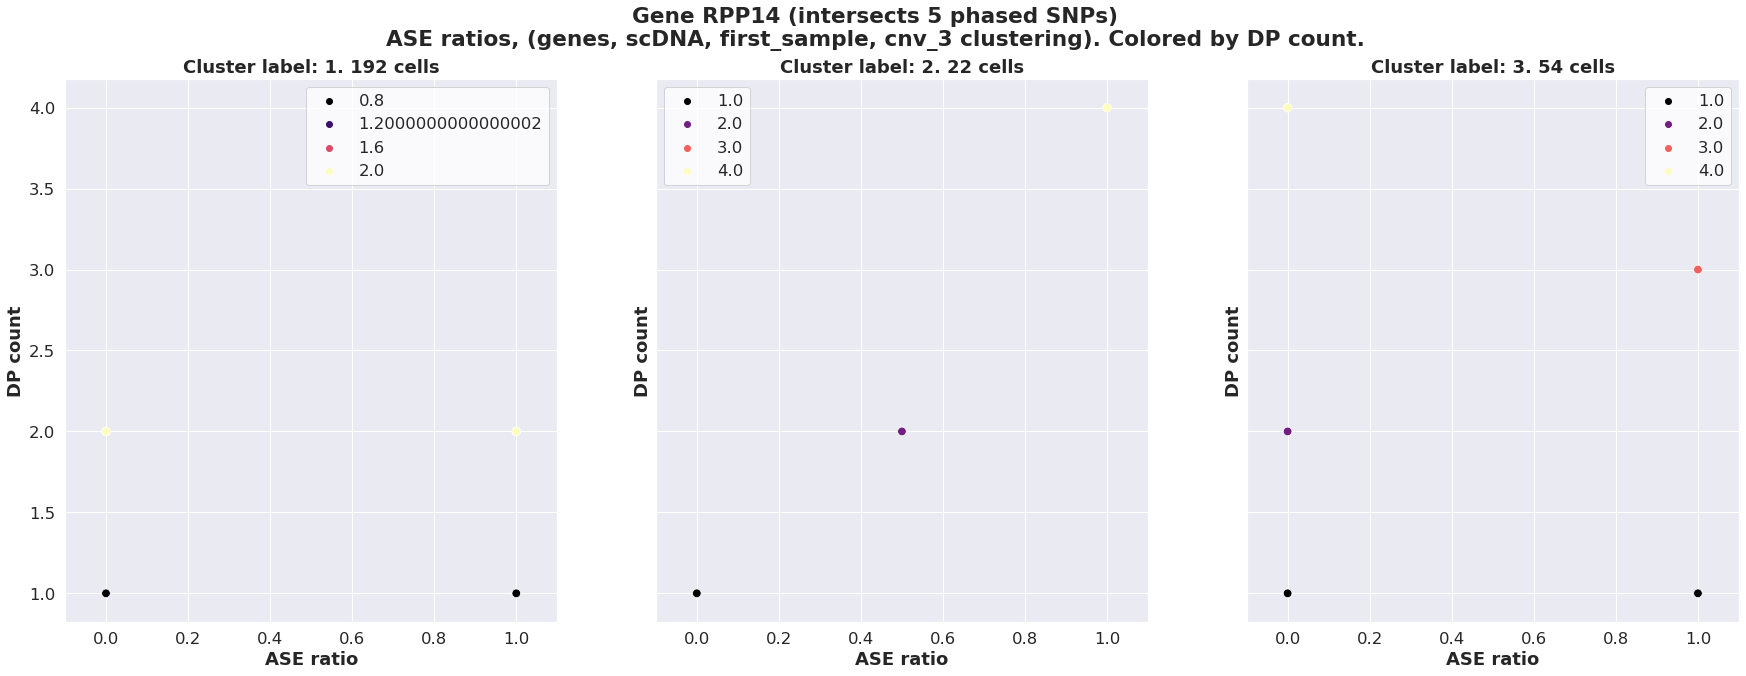

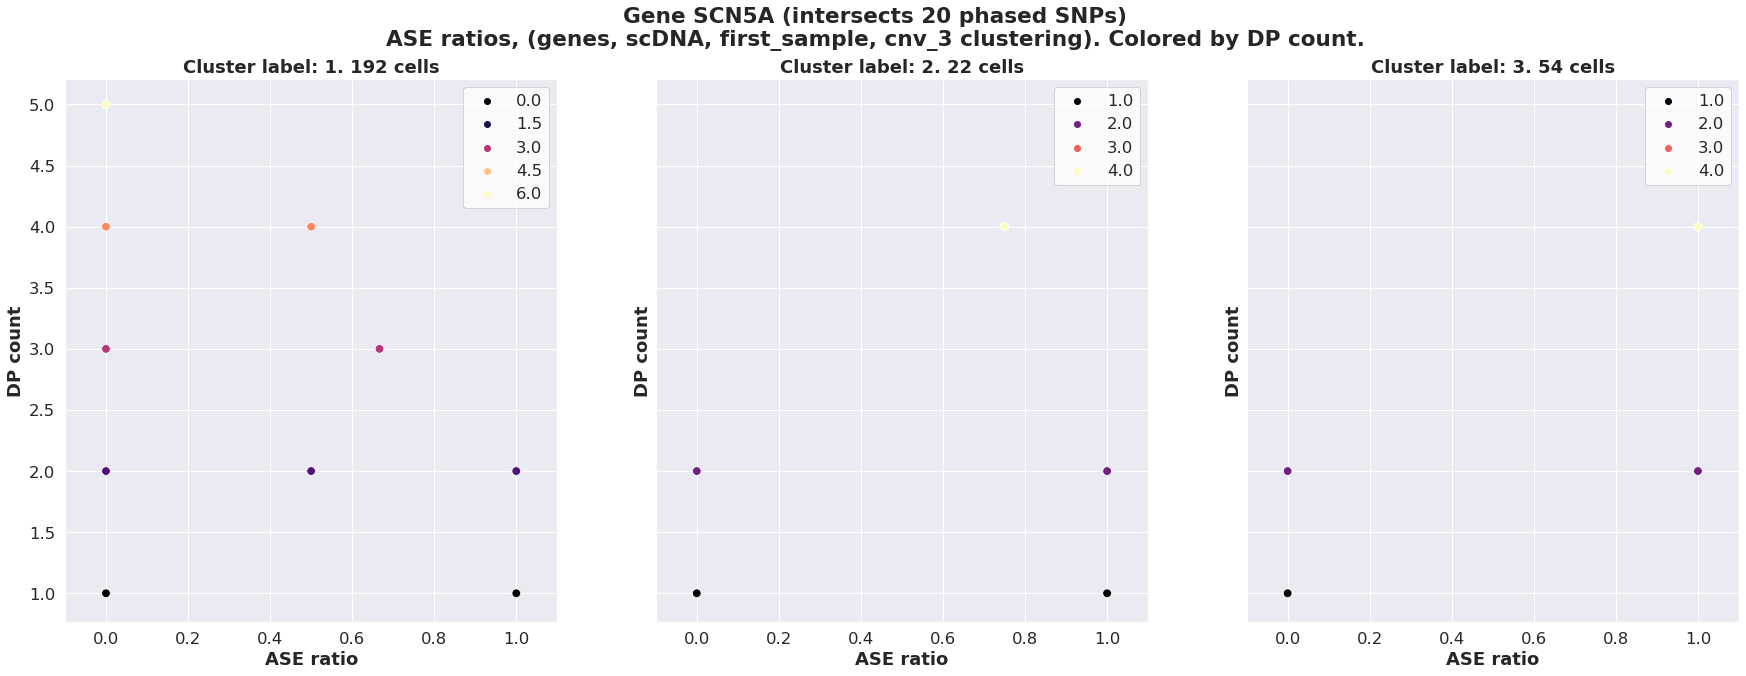

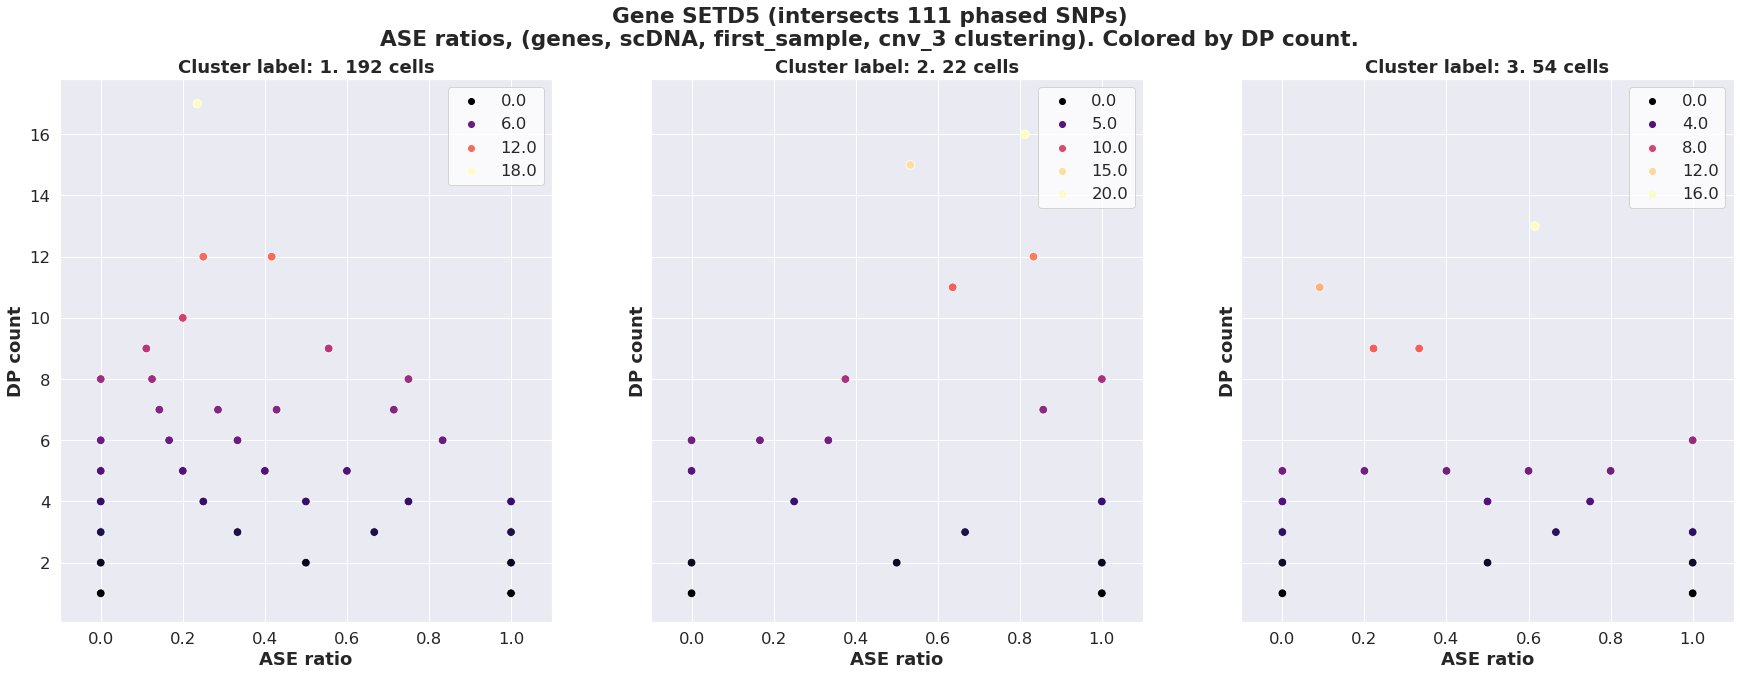

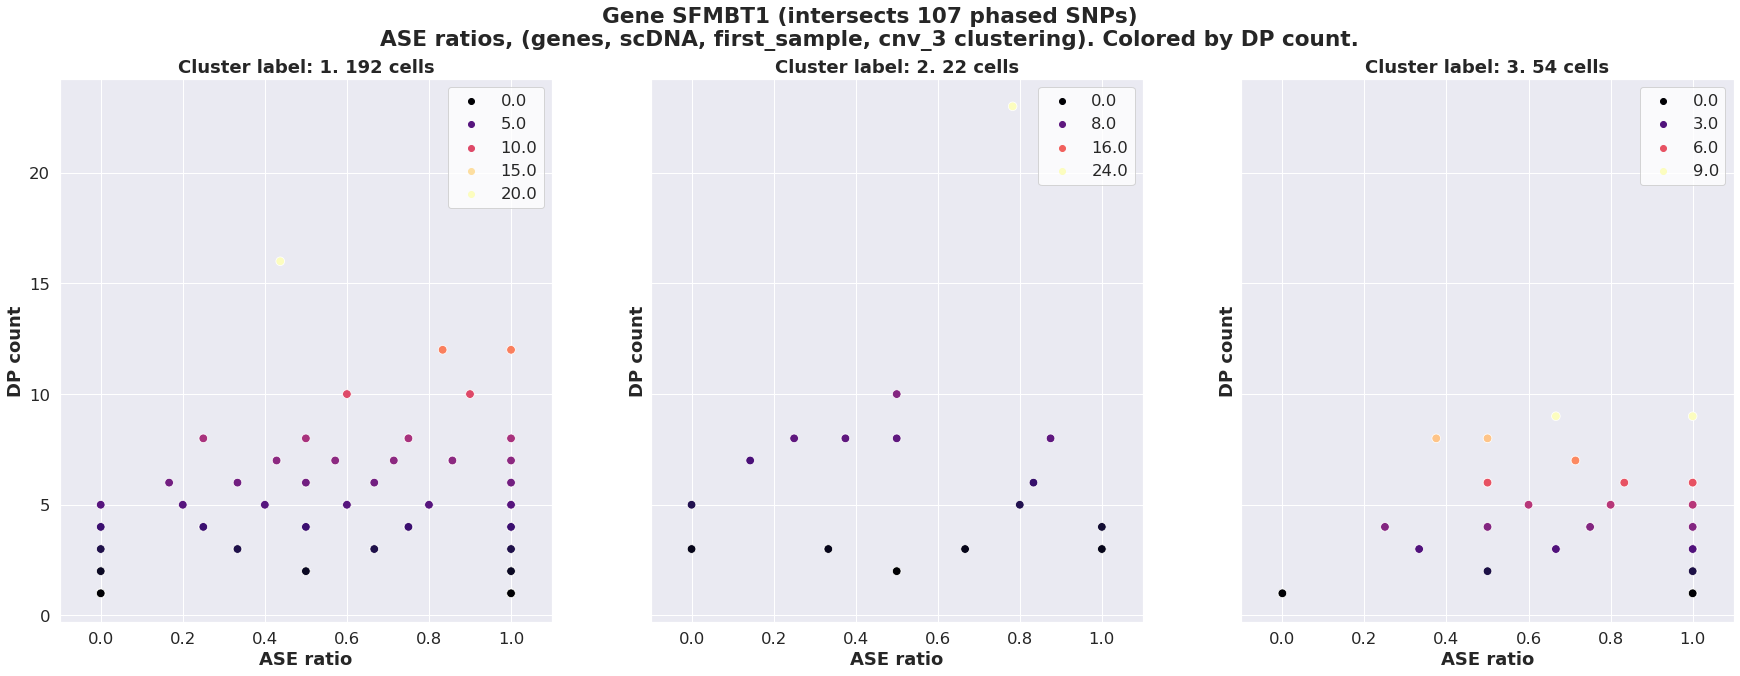

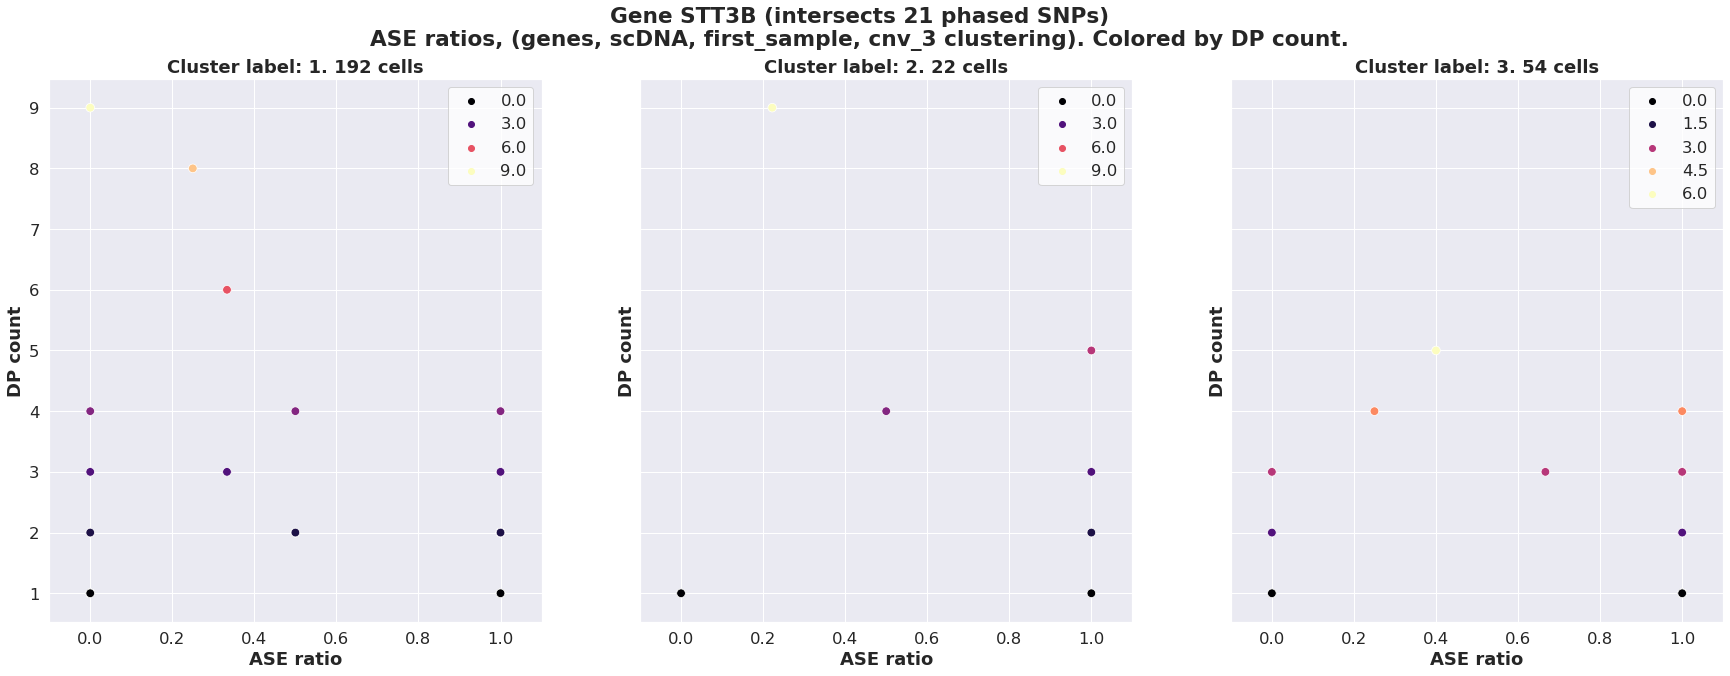

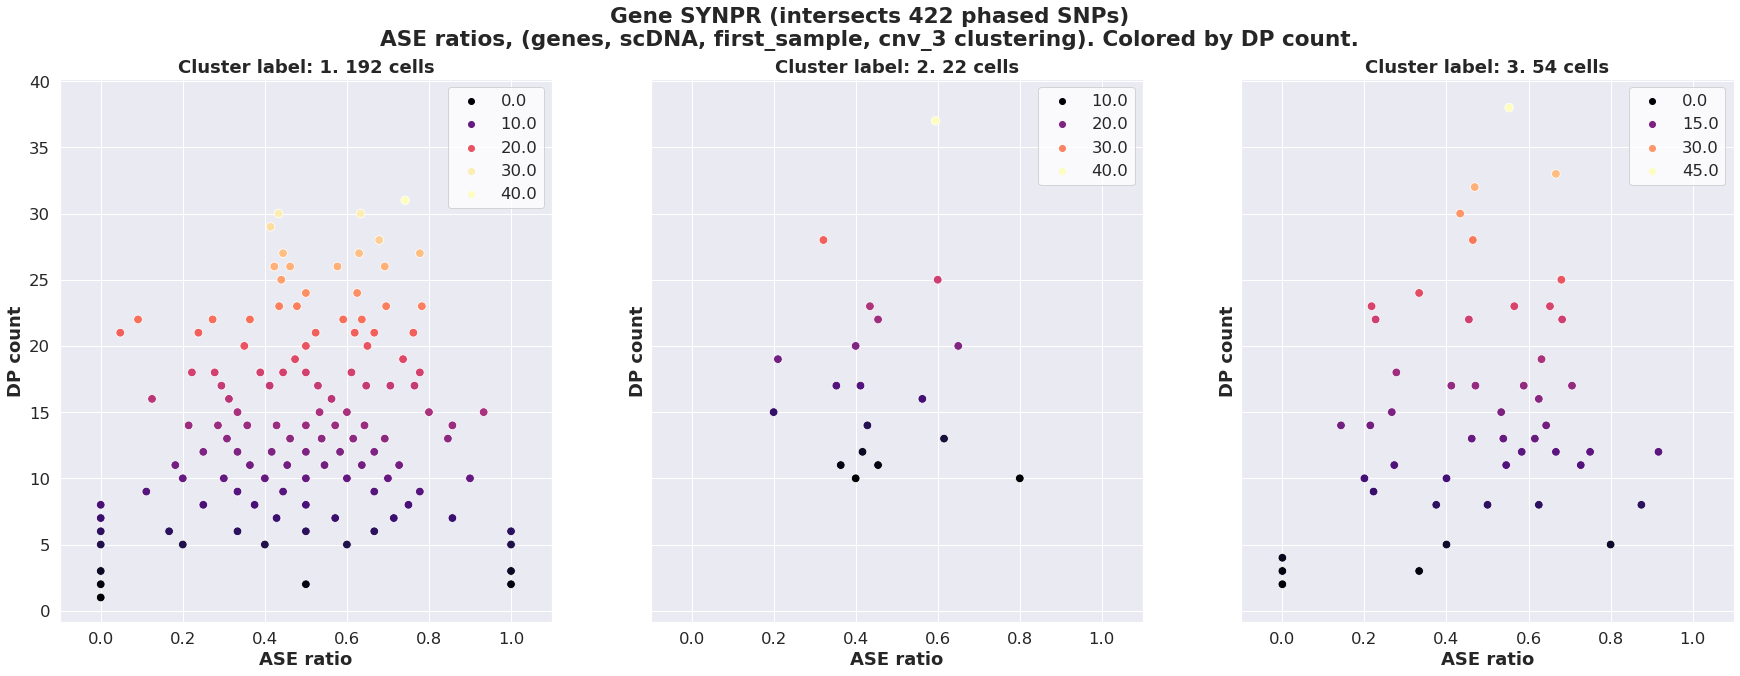

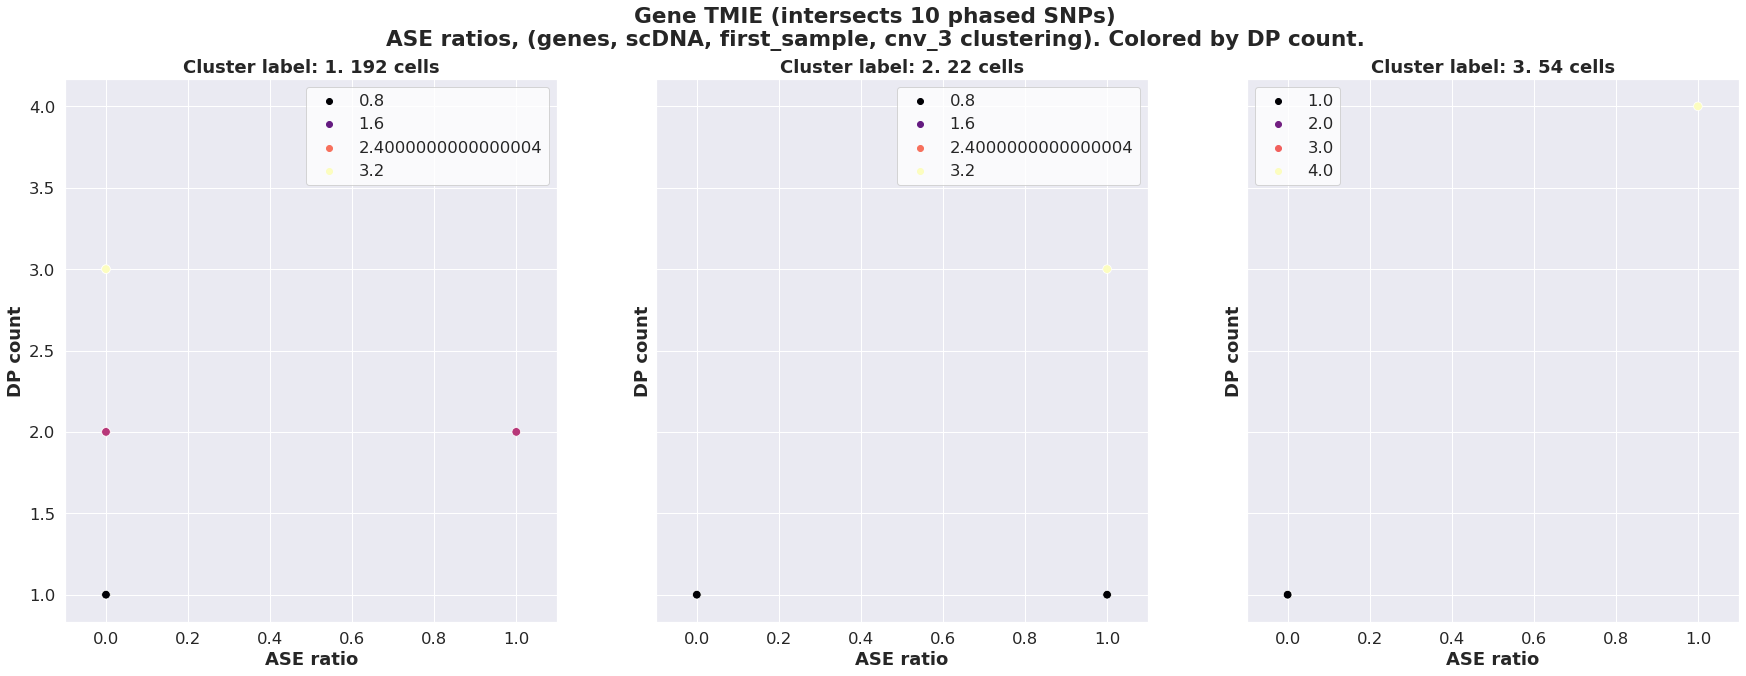

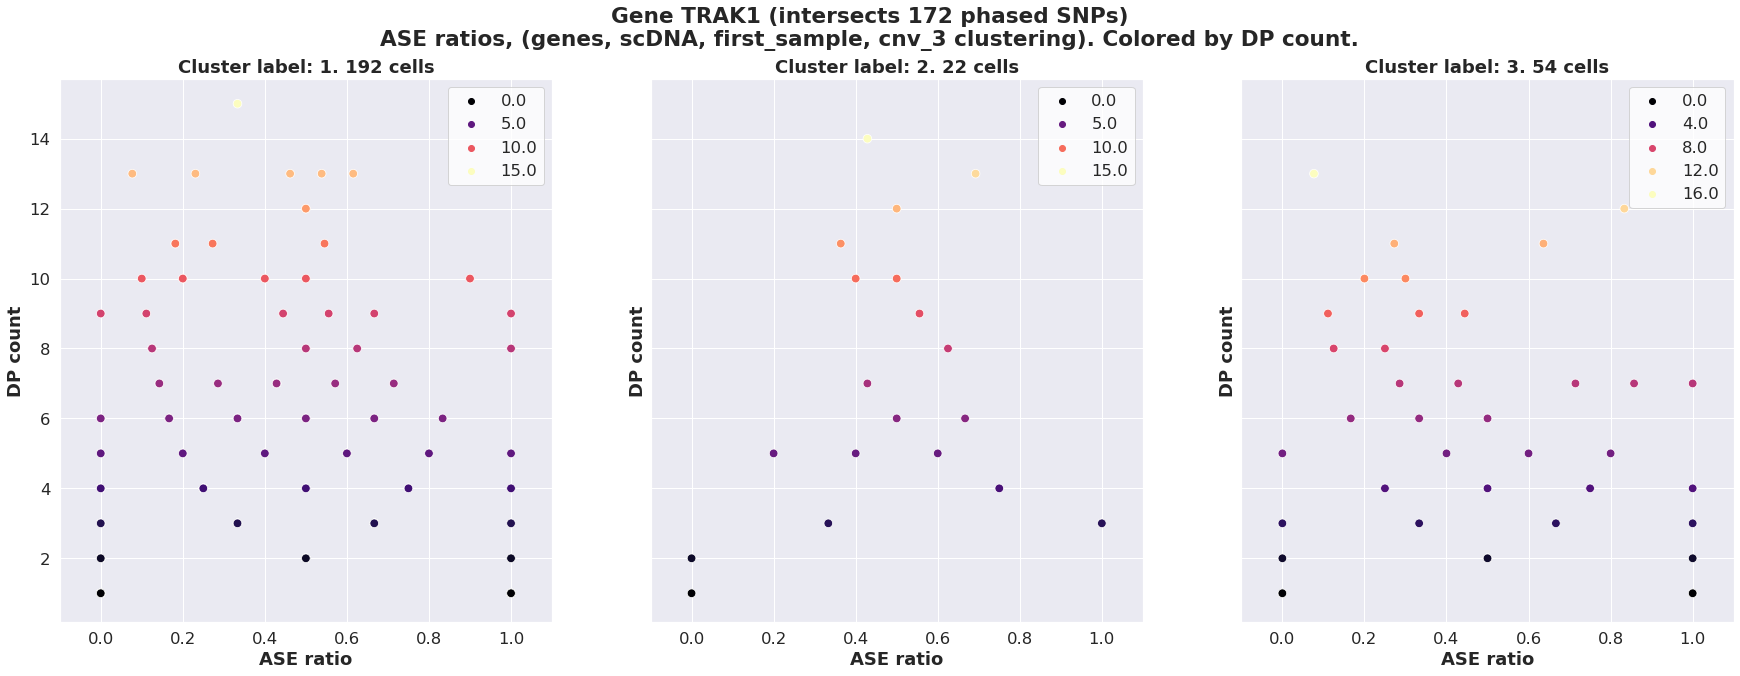

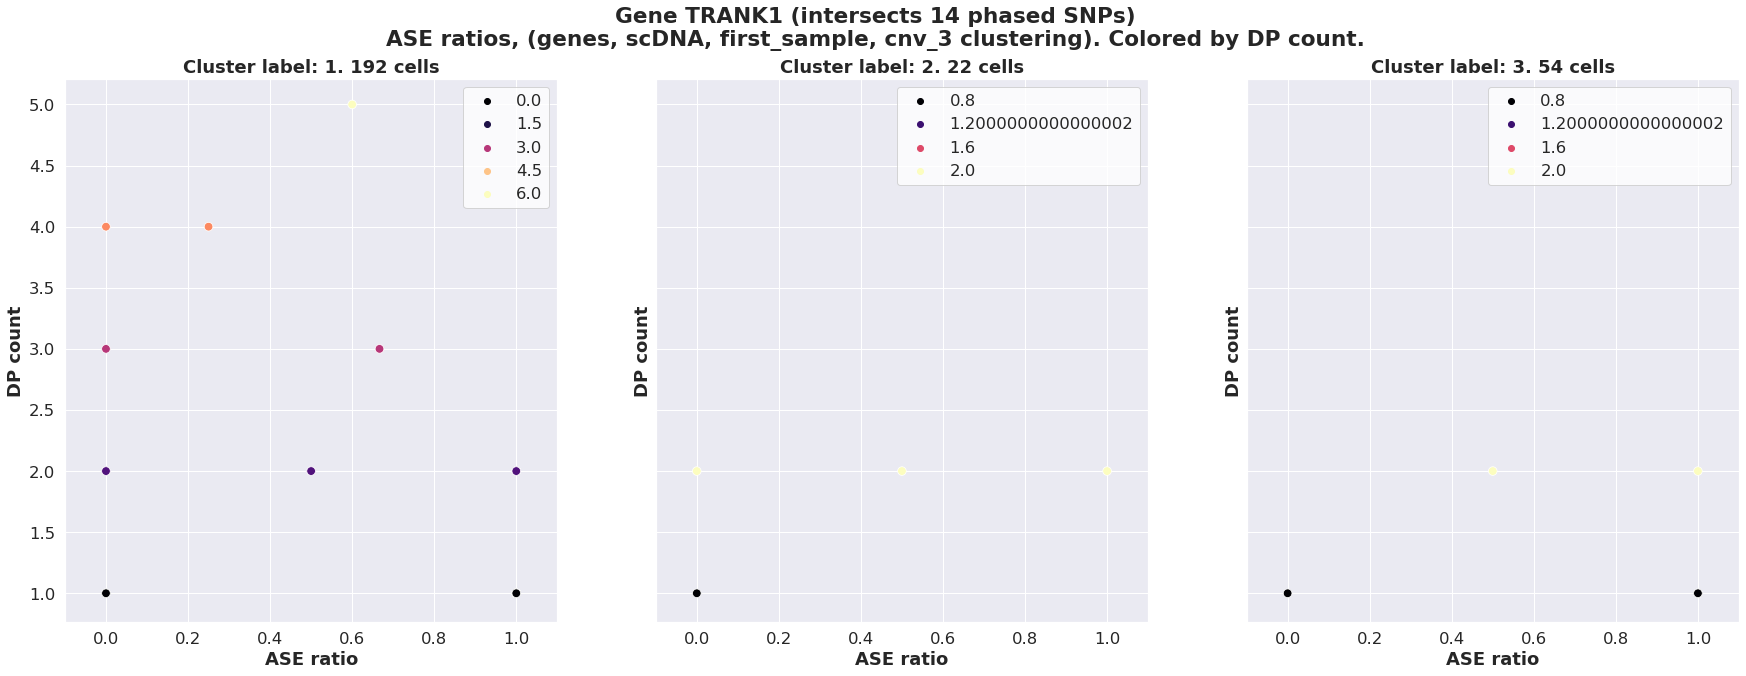

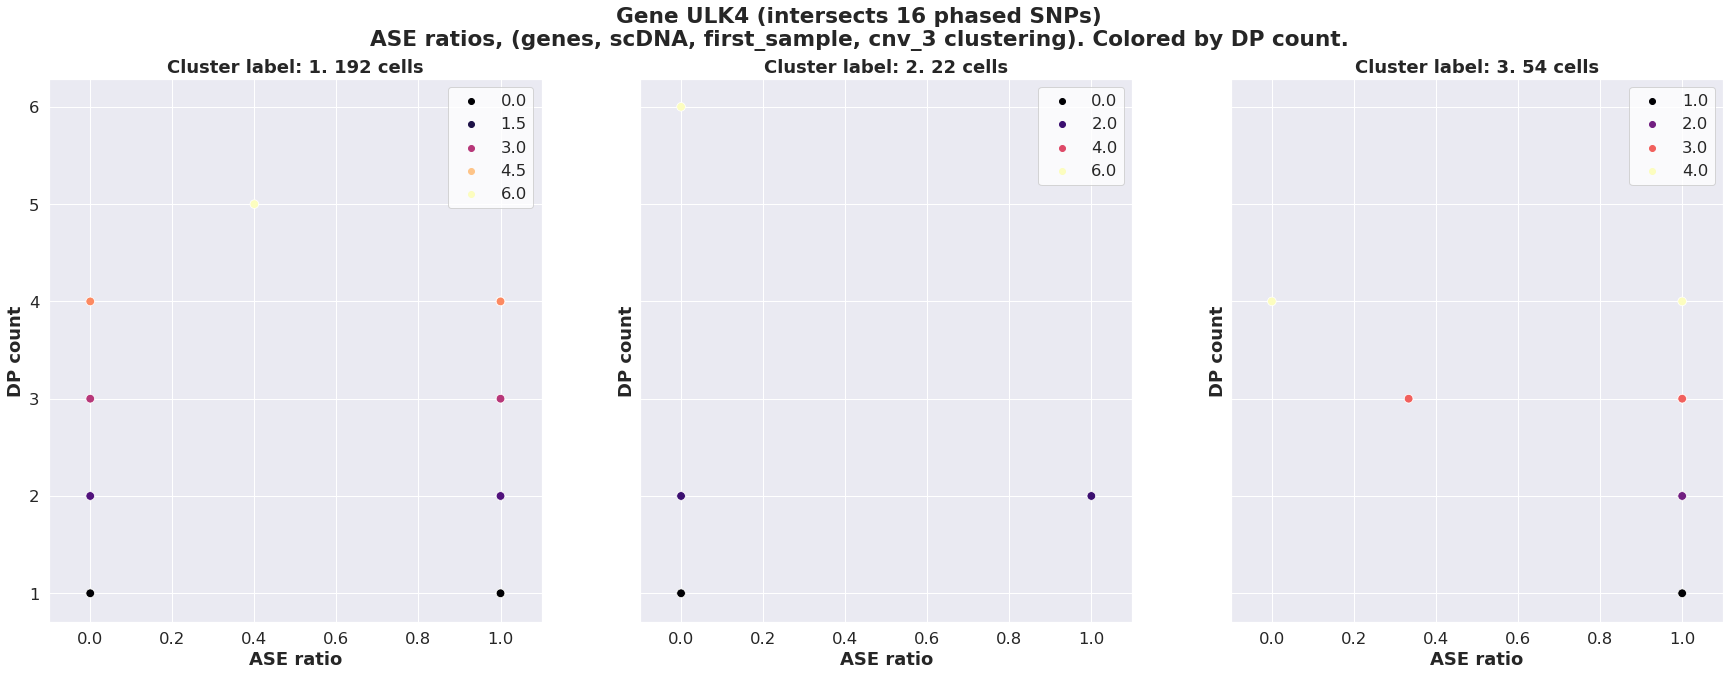

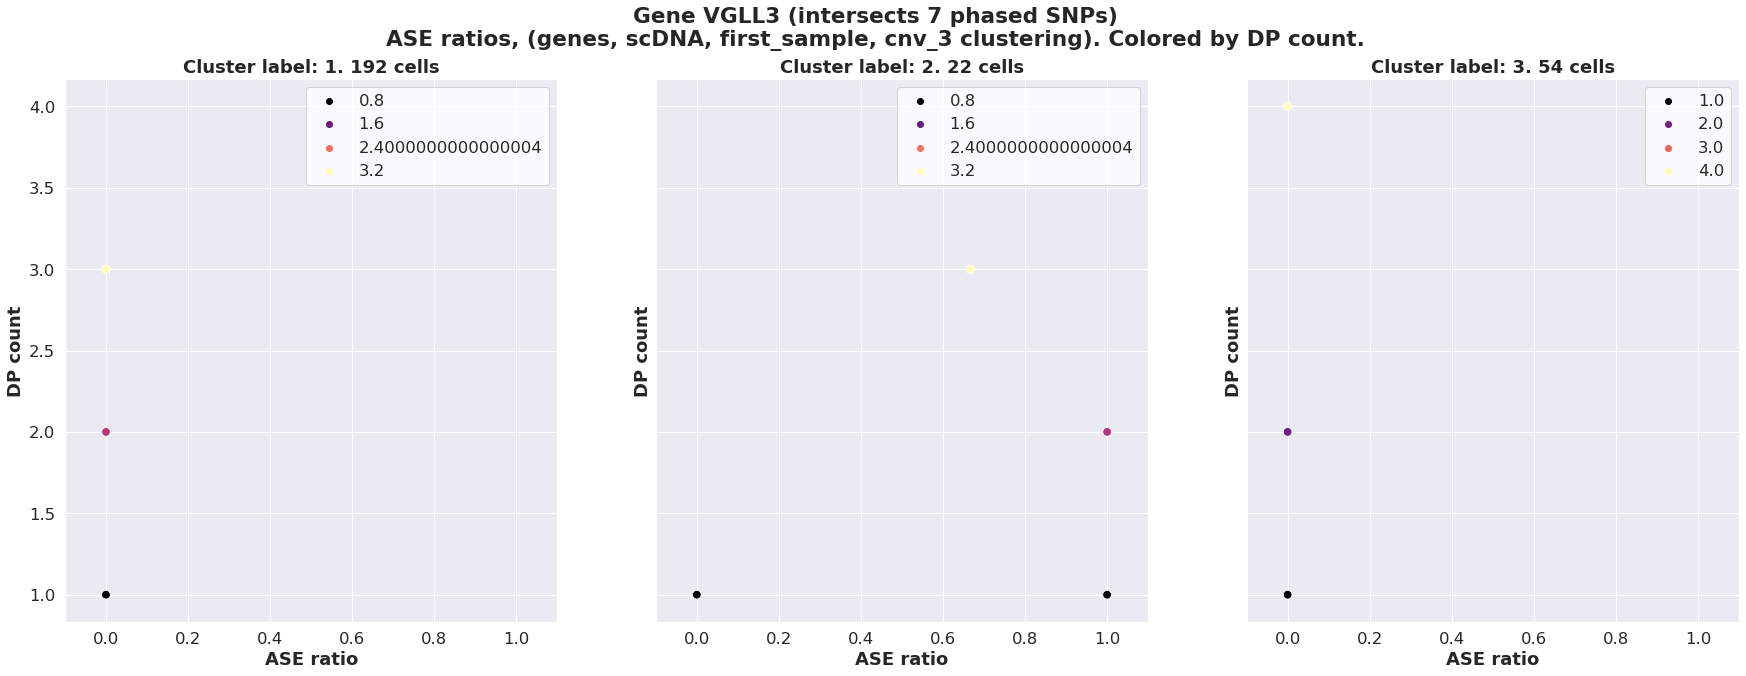

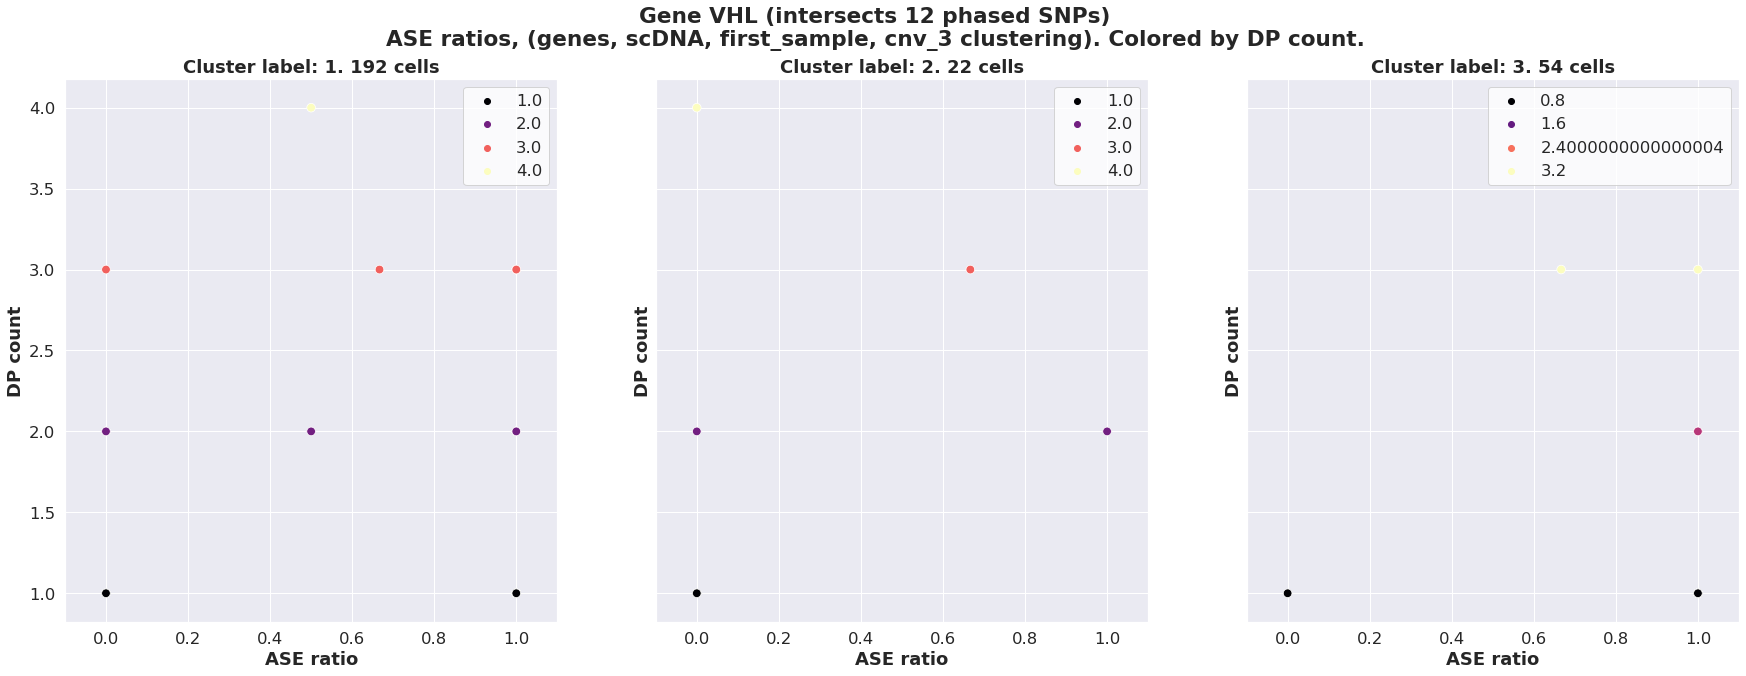

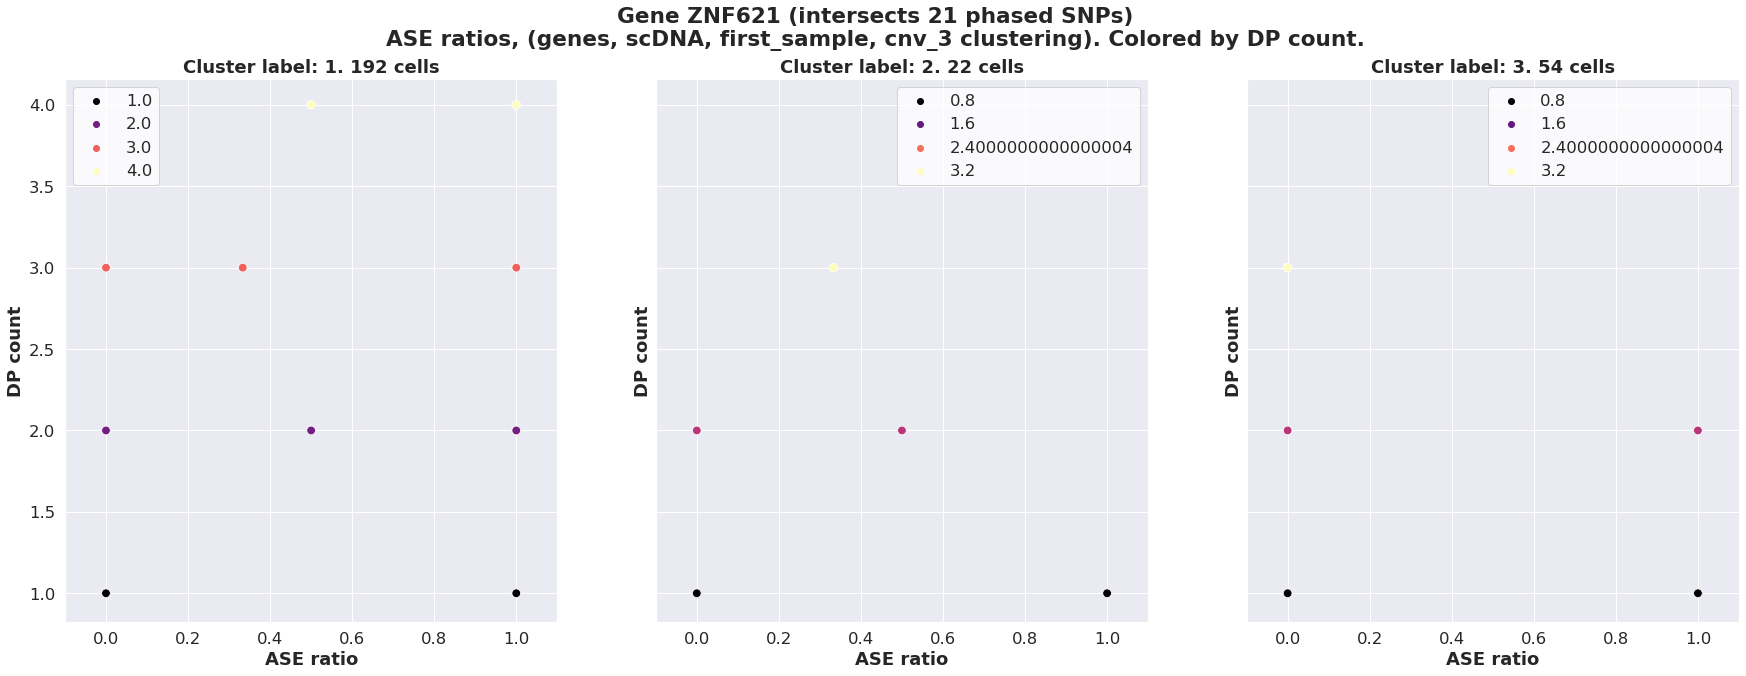

In [26]:
for test_gene_name in tqdm_notebook(test_gene_name_list, 
                                    "processing genes on 3p"):
    print(test_gene_name)
    test_loc = np.ravel(
        np.where(
            data["genome"]["GENE_NAME"].apply(
                lambda gene_list: test_gene_name in gene_list.split(',')
            )
        )
    )
    if not test_loc:
        print(f"{test_gene_name} is not found in the reference genome (hg19)")
        continue
        
    test_gene_id = data["genome"]["GENE_ID"].iloc[test_loc].values[0]
#     print(test_gene_id)
    snps_covered = data["gene_to_snps"][test_gene_id]
    if not snps_covered:
        print(f"{test_gene_name} doesn't intersect phased SNPs")
        continue
        
    unique_labels = data['clustering']['LABEL'].unique()
    unique_labels.sort()
    n_clusters = unique_labels.size

    fig, axes = plt.subplots(
        1, n_clusters, 
        figsize=(10 * n_clusters, 10),
        sharey=True
    )
    fig.suptitle(
        f"Gene {test_gene_name}"
        f" (intersects {len(snps_covered)} phased SNPs)\n"
        "ASE ratios,"
        f" (genes, {data_name}, {sample_name}, {clustering_name} clustering)."
        " Colored by DP count.\n",
        weight="bold"
    )
    sns.set(font_scale=1.5)

    for i, label in enumerate(unique_labels):
        ax = axes[i]
        cluster_barcodes = data['clustering']\
            .query(f"LABEL == {label}")["BARCODE"]
        cluster_counts = data['gene_counts'][
            data['gene_counts'].columns.intersection(
                np.hstack((
                    ["GENE_ID"],
                    np.hstack([
                        f"{barcode}_ad",
                        f"{barcode}_dp"
                    ] for barcode in cluster_barcodes
                )))
            )
        ]
        tmp_df = cluster_counts[
            cluster_counts['GENE_ID']\
            .isin([test_gene_id])
        ]
        informative_column_list = [
            [f"{barcode}_ad",f"{barcode}_dp"] 
            for barcode in cluster_barcodes 
            if (~np.isnan(tmp_df[f"{barcode}_dp"].values) 
                and tmp_df[f"{barcode}_dp"].values > 0)
        ]
        if not informative_column_list:
            print(f"{test_gene_name} is not expressed in cluster {label}")
            continue
            
        tmp_df = tmp_df[
            tmp_df.columns.intersection(
                np.hstack(informative_column_list)
            )
        ]
        tmp_ase_df = ase_matrix.compute_ase(
            tmp_df,
            toolkit.extract_barcodes(tmp_df)
        )
        assert np.all(tmp_ase_df <= 1)
        ax.set_title(
            f"Cluster label: {label}. {len(cluster_barcodes)} cells", 
            weight="bold"
        )
        ax.set_xlabel("ASE ratio", weight="bold")
        ax.set_ylabel("DP count", weight="bold")
        tmp_counts = toolkit.extract_counts(tmp_df).values.ravel()
        sns.scatterplot(
            ax=ax,
            x=tmp_ase_df.values.T.ravel(), 
            y=tmp_counts,
            s=75,
            hue=tmp_counts,
            palette="magma"
        )
        ax.set_xlim(-0.1, 1.1)
        ax.legend().get_frame().set_facecolor("white")
    fig.show()

KeyError: 'AACTCCCAGGGATTCG-1_ad'

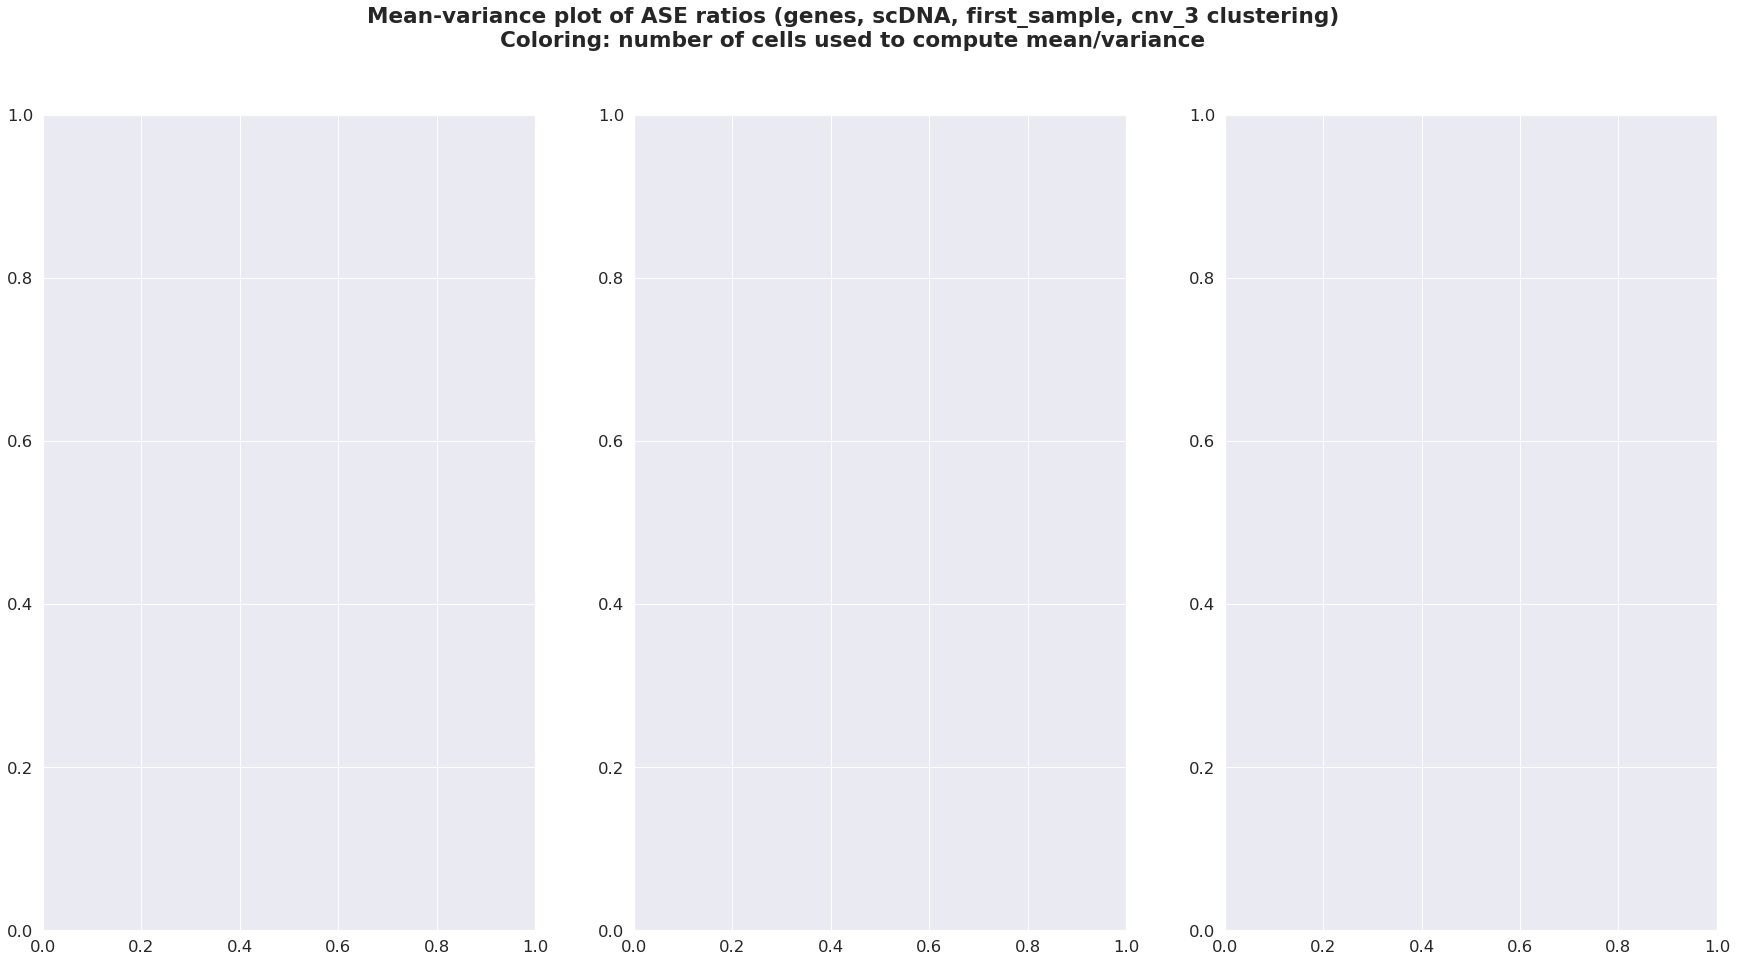

In [31]:
unique_labels = data['clustering']['LABEL'].unique()
unique_labels.sort()
n_clusters = unique_labels.size
fig, axes = plt.subplots(1, n_clusters, figsize=(10 * n_clusters, 15))
fig.suptitle(
    "Mean-variance plot of ASE ratios"
    f" (genes, {data_name}, {sample_name}, {clustering_name} clustering)\n"
    "Coloring: number of cells used to compute mean/variance",
    weight="bold"
)
sns.set(font_scale=1.5)

for i, label in enumerate(unique_labels):
    ax = axes[i]
    cluster_barcodes = data['clustering']\
        .query(f"LABEL == {label}")["BARCODE"]
    cluster_counts = cluster_counts[
        cluster_counts.columns.intersection(
            np.hstack((
                ["GENE_ID"],
                np.hstack([
                    f"{barcode}_ad",
                    f"{barcode}_dp"
                ] for barcode in cluster_barcodes
            )))
        )
    ]
    
    cluster_counts[cluster_counts == 0] = np.nan
    cluster_ase = ase_matrix.compute_ase(
        cluster_counts,
        cluster_barcodes
    )
#     print(cluster_ase[cluster_counts["GENE_ID"] == faulty_gene_id])
#     points = np.column_stack((
#         cluster_ase.mean(axis=1) - 0.5, 
#         cluster_ase.var(axis=1)
#     ))
#     ax = axes[i]
#     ax.set_title(f" Cluster label: {label}.\n"
#                  f"{cluster_barcodes.size} cells,"
#                  f" {cluster_counts.shape[0]} genes", 
#                  weight="bold")
#     ax.set_xlabel("mean - 0.5", weight="bold")
#     ax.set_ylabel("variance", weight="bold")
#     hue = (~toolkit.extract_counts(
#         cluster_counts, suffix="dp"
#     ).isna()).sum(axis=1)
#     sns.scatterplot(
#         points[:, 0],
#         points[:, 1],
#         ax=ax,
#         hue=hue,
#         palette="magma"
#     )
#     ax.axvline(0, linestyle="--", color="red")
#     frame = ax.legend(framealpha=1).get_frame()
#     frame.set_facecolor("white")
#     ax.get_legend().remove()

In [172]:
data['clustering'].query("LABEL == 2").shape

(22, 4)

# Clustermaps depicting present-to-missing ratio

In [ ]:
%%time
sys.setrecursionlimit(int(1e6))
sns.clustermap(
    toolkit.extract_counts(data["gene_counts"], "dp")\
    .iloc[:, :500].fillna(0) > 0,
    row_cluster=False
)

In [ ]:
%%time
sys.setrecursionlimit(int(1e6))
sns.clustermap(
    toolkit.extract_counts(data["gene_counts"], "dp")\
    .iloc[:, :500].fillna(0) > 0,
    row_cluster=True
)

# Overall count depth analysis

In [3]:
total_dp_counts = np.zeros(data["counts"].shape[0])
for barcode in tqdm(
    toolkit.extract_barcodes(data["counts"]),
    "processing barcodes"
):
    total_dp_counts += data["counts"]\
                        [f"{barcode}_dp"]\
                        .to_dense()\
                        .fillna(0)\
                        .values

processing barcodes: 100%|██████████| 268/268 [00:06<00:00, 41.83it/s]


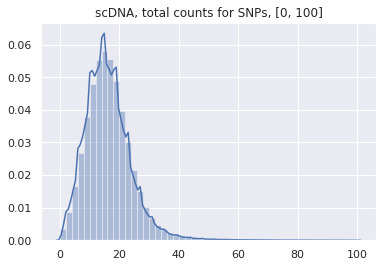

In [11]:
plt.title(f"{nb_config['experiment_info']['data']}"
          ", total counts for SNPs, [0, 100]")
sns.distplot(total_dp_counts[total_dp_counts <= 100]);

In [5]:
summary_df = pd.DataFrame(total_dp_counts)\
.describe(percentiles=np.arange(0,1,0.05))\
.astype(int).T
summary_df

count  mean  std  min  0%  5%  10%  15%  20%  25%  ...  55%  60%  65%  \
0  1552849    16   38    0   0   5    7    9   10   11  ...   16   17   18   

   70%  75%  80%  85%  90%  95%    max  
0   19   20   22   23   26   30  29898  

[1 rows x 25 columns]

In [6]:
quantile = "75%"

In [7]:
above_quantile = [
    f"{chrom},{pos}" for chrom, pos 
    in data["counts"][["CHROM", "POS"]]\
        [total_dp_counts >= summary_df[quantile].values]\
        .values\
        .astype(int)
]

In [17]:
snp_in_gene_mask = np.array([len(data["snp_to_genes"][snp]) >= 1 
                             for snp in above_quantile])
print(
    "{:.2f}% ({} out of {}) of SNPs with non-zero count depth intersect genes"
    " \nand have more than 30 (95% percentile) reads mapped"\
    .format( 
        100 * np.mean(snp_in_gene_mask),
        np.sum(snp_in_gene_mask), snp_in_gene_mask.size
    )
)

47.44% (209143 out of 440895) of SNPs with non-zero count depth intersect genes 
and have more than 30 (95% percentile) reads mapped


In [21]:
gene_to_snp_counts_ratio = (
    toolkit.extract_counts(data["counts"], suffix="dp").sum()
    / toolkit.extract_counts(data["gene_counts"], suffix="dp").sum()
)

(array([  1.,   0.,   2.,   3.,  30., 128.,  69.,  24.,   6.,   5.]),
 array([0.44784933, 0.45360587, 0.45936241, 0.46511895, 0.47087549,
        0.47663203, 0.48238857, 0.48814511, 0.49390165, 0.49965819,
        0.50541473]),
 <a list of 10 Patch objects>)

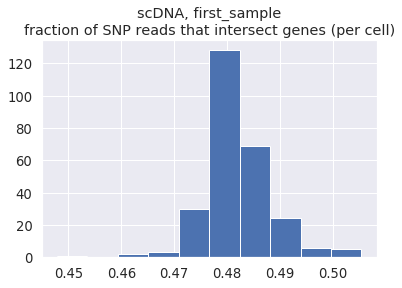

In [35]:
plt.title(f"{data_name}, {sample_name}\n"
          "fraction of SNP reads that intersect genes (per cell)")
plt.hist(1 / gene_to_snp_counts_ratio)

537 columns, 268 barcodes, 15819 genes


/icgc/dkfzlsdf/analysis/B260/users/v390v/cnv_inference/lib/plotlib.py:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


CPU times: user 570 ms, sys: 92.8 ms, total: 663 ms
Wall time: 657 ms


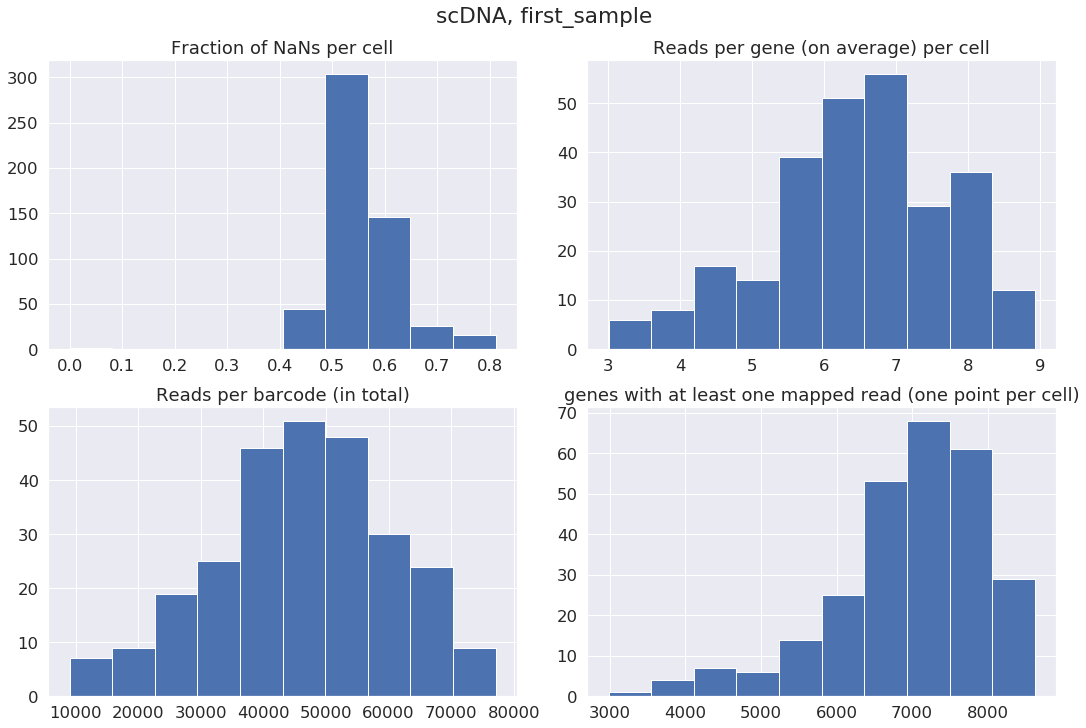

In [36]:
%%time
sns.set(font_scale=1.5)
plotlib.describe_read_counts(
    data["gene_counts"], 
    f"{data_name}, {sample_name}", 
    feature_name="gene"
)

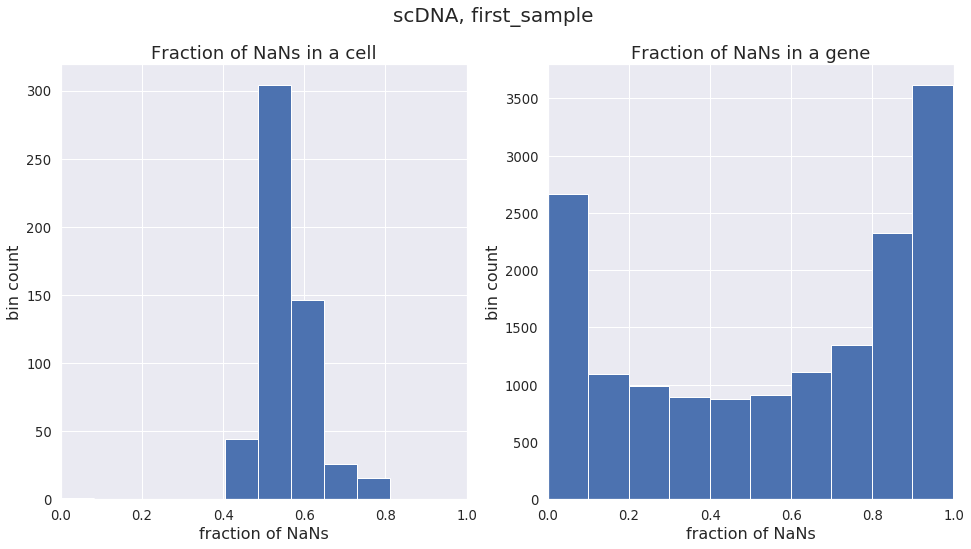

In [32]:
util.nan_fraction(
    data["gene_counts"], 
    axis_list=[0, 1],
    suptitle=f"{data_name}, {sample_name}",
    verbose=False,
    show_plots=True,
    axis_to_name={1 : "gene", 0 : "cell"},
    outfile=f"{nb_config['img_dir']['sample']}/nan_fraction.pdf"
);